# 第11讲：性能优化指南：从冷启动到响应加速你的RAG

>在前面的课程中我们从检索和生成两个角度学习了多种提升 RAG（Retrieval-Augmented Generation）系统效果的策略和相关评测方法。为了获得更好的检索召回效果，我们介绍了通过多个子查询、多个节点组、多个检索器进行检索，同时引入了重排序模型。虽然我们成功提升了系统的召回效果，但更多环节及模型的引入也增加了许多计算和推理成本，系统的整体执行时间随之增加。在实际应用中，除了系统效果，我们同样需要关注系统的执行效率，即系统是否能够快速响应用户请求，以及是否能够快速实现文档和算法的迭代。本篇教程将带您学习一系列提升 RAG 系统运行效率的相关策略。

在RAG系统的构建过程当中，除了“搜的准”、“答的好”，系统的执行效率同样是一个需要关注的话题。在一个真正面向落地的知识库问答系统的开发过程当中，许多开发者常常会面临一个核心难题：**响应慢，体验差，优化无从下手**。究其根本，这类问题往往与系统各阶段的性能瓶颈有关。

一个典型的 RAG 系统包含三大阶段：**文档入库、检索召回与生成推理**。下图标注了上述 RAG 各环节中影响整体系统性能的主要因素：

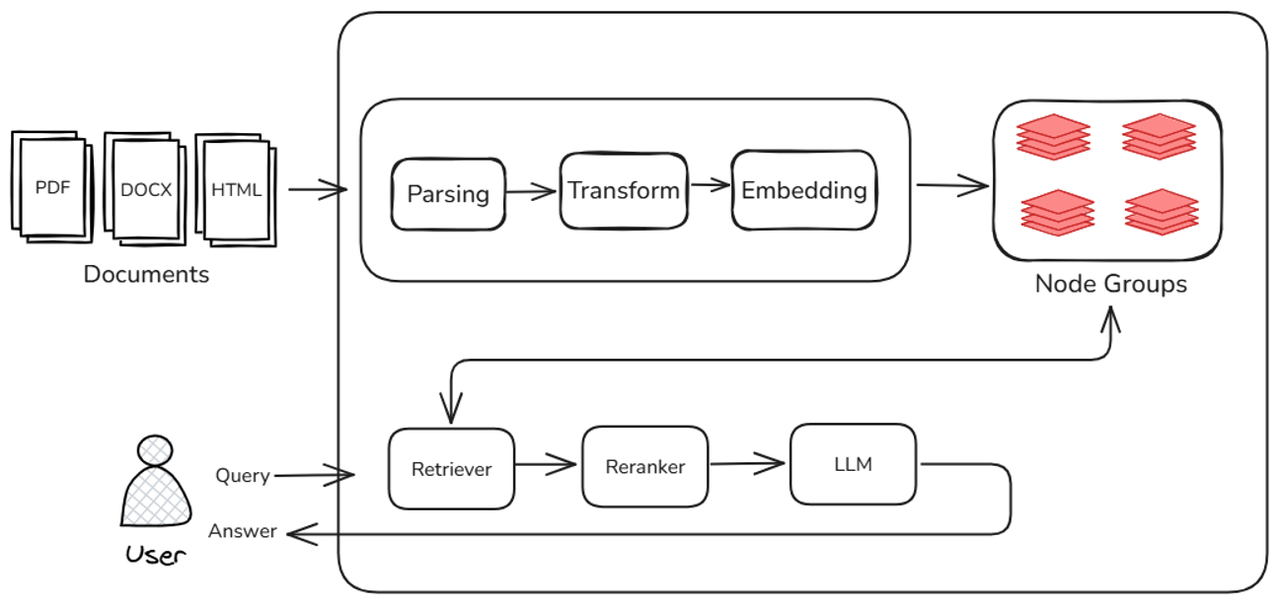


- 在**文档入库阶段**，系统需对海量原始文档进行解析、分块、摘要提取、向量化等处理。这一阶段对系统“首次启动”或“数据更新”的耗时有决定性影响。**文档越多，启动越慢**；处理逻辑越复杂，占用内存和计算资源越多。
- 在**检索召回阶段**，系统存在多个检索器，系统需在不同的节点组中执行高维向量匹配、关键词匹配或QA段落匹配等操作。在这个过程当中，**检索效率的高低，直接决定了用户等待时间的长短**。若向量索引结构不合理或检索算法未做优化，将显著拖慢整体响应速度。
- 在**生成推理阶段**，召回结果送入大模型生成模块，完成最终答案的生成。该阶段的延迟主要与大语言模型本身的推理速度有关。但实际上，**生成模块的延迟并非孤立存在，也会受到前端检索效率的牵制**：检索慢→输入晚→推理延迟累积，最终影响整体用户体验。同样，虽然流式输出大幅优化了用户在问答过程中的体验，但在RAG整个链路当中，其也只能在最后的回答阶段发挥作用。其他需要大模型参与的环节（如关键信息提取、问题重写等），会收到模型推理性能的较大影响。

> p.s. 流式输出只能缩短答案生成的首字延迟，无法缓解中间阶段使用模型带来的延迟

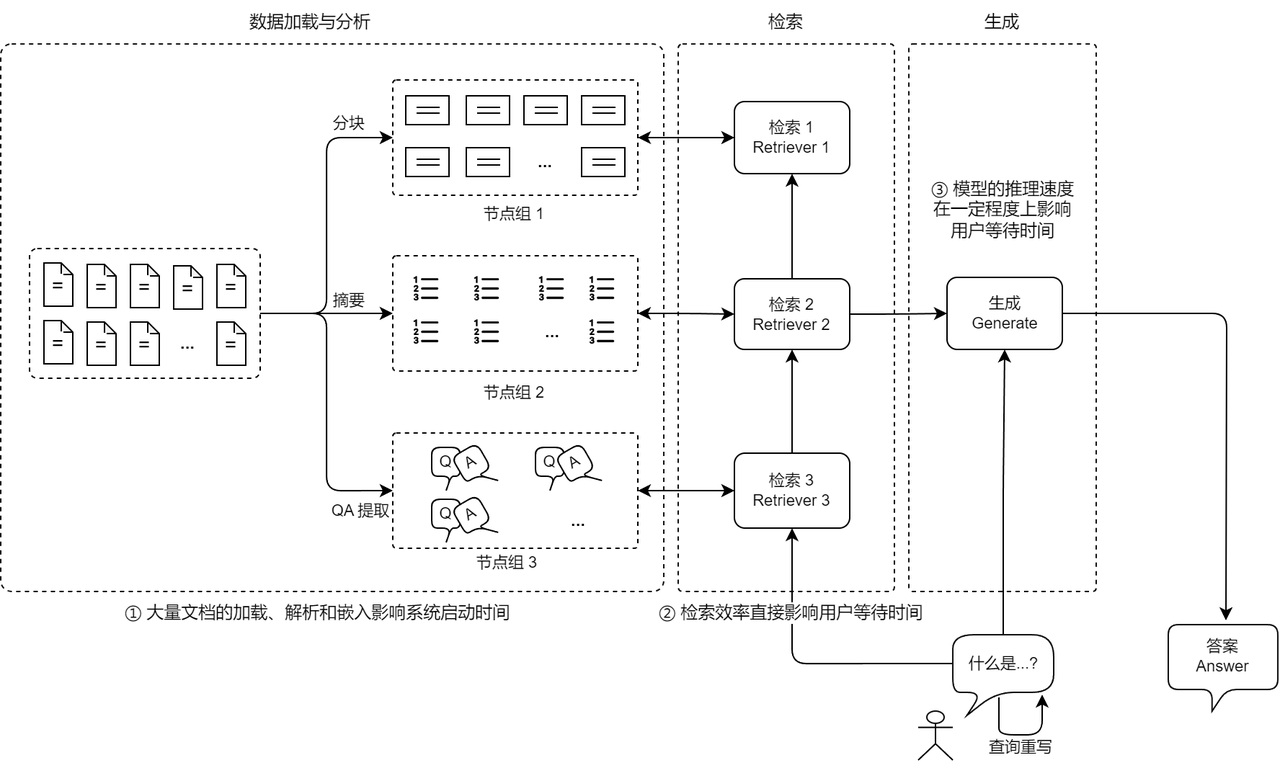

RAG 的性能瓶颈分析


RAG 系统的运行效率受到多个维度的制约，**任一环节掉链子，都会造成响应瓶颈**。本节教程将**从硬件与软件两个层面，深入剖析 RAG 系统中的性能瓶颈与优化策略，帮助开发者系统性地提升整体响应速度与用户体验**。教程重点围绕以下三个话题展开：

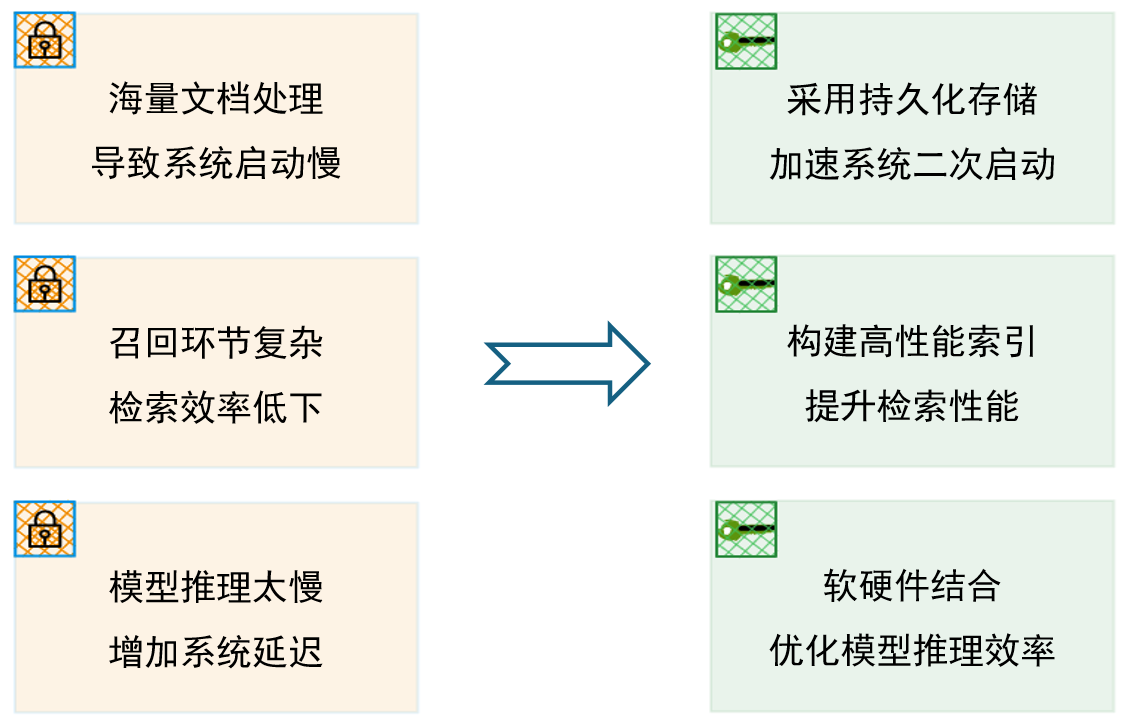


1. **采用持久化存储，提升系统重启与数据加载效率** 从计算机的运行原理出发，讲解各类存储介质的读写特性与区别，利用持久化存储来减少二次启动时的数据加载、解析和索引构建时间，为系统“热启动”和“容灾恢复”提供优化思路。同时，介绍使用缓存机制以节省系统运行时高命中率数据带来的性能损耗。
2. **选择更高效的向量索引，提升向量检索效率** 系统梳理标量索引与向量索引的数据结构、适用场景以及高效的ANN检索算法，对比主流向量数据库在构建速度、查询性能、内存消耗等方面的表现，帮助开发者选型落地，同时介绍LazyLLM在相关方面的支持。
3. **优化大模型的推理效率，在生成阶段降低延迟** 系统介绍基于软硬件的模型加速方法及模型量化、模型蒸馏等技术，提升模型的推理速度从而加速系统整体运行速度，提升 RAG 系统的用户体验。

# 一、持久化存储

## 1.1 计算机工作流程

首先我们回顾一下计算机的基本工作原理，主要涉及 **CPU**、**内存** 和 **外部存储（如硬盘）** 三大核心组件。当计算机运行程序时，CPU 首先会通知操作系统**从硬盘中加载程序至内存**，程序加载完毕后，CPU 从内存中读取指令并开始执行。如果程序需要操作文件（如读取或写入），它会通过操作系统请求文件系统访问硬盘**。数据会从硬盘加载到内存**，程序再从内存中读取或修改这些数据，写入操作则**先写入内存缓存，最终由操作系统写入硬盘，确保数据持久保存**。

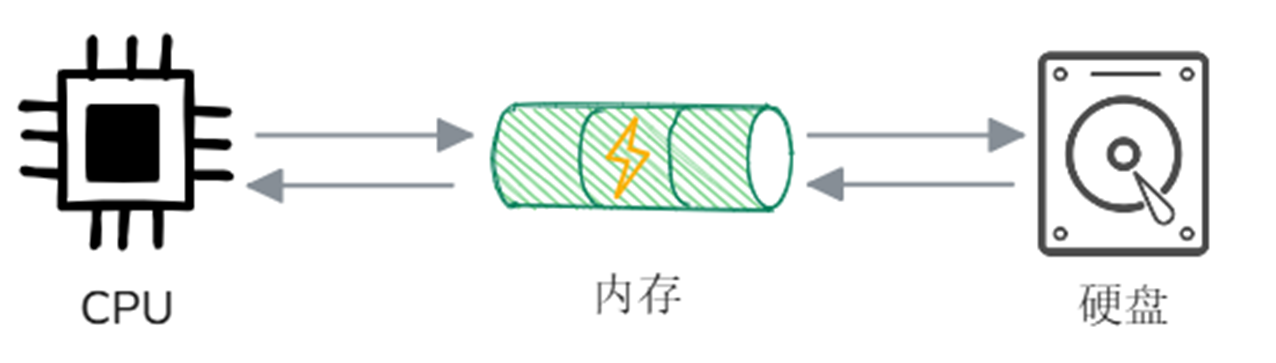

结合以上流程描述，我们便可以尝试描述一下先前搭建的RAG系统是如何工作的：

- **系统启动阶段**：在这个阶段，程序首先会从硬盘加载至内存当中，并在加载完毕后运行。随后会进行文档入库环节，该环节中CPU会请求文件系统**访问硬盘**，将期望入库的**文件加载至内存**并读取，并在内存当中依次进行解析、分块、向量化，并在上述流程完成后，将**向量与文档切片暂存在内存**当中。
- **用户问答阶段**：用户提出的查询同样会被**加载至内存**，随后系统会根据检索类型（关键词/向量）执行检索算法，在暂存在内存中的切片集合中找到相似的文档切片，并将这些切片与提示词结合，一并输入至大模型。最后，大模型会根据输入给出回答。


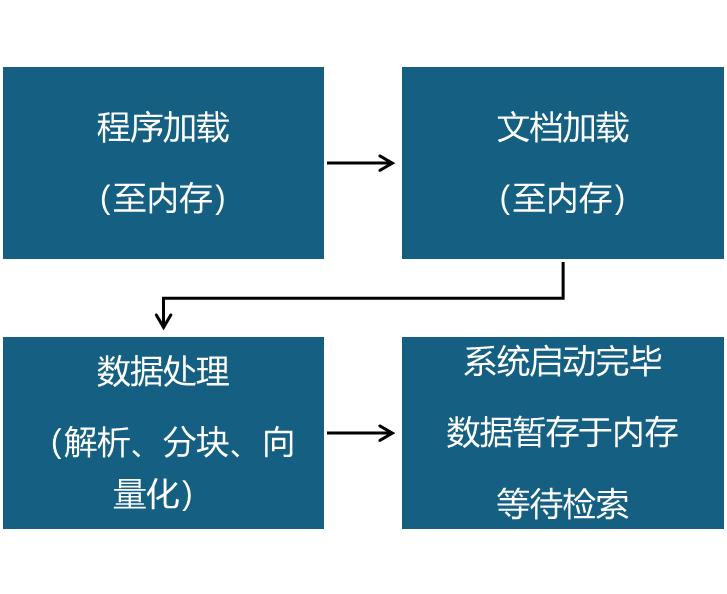


细心的你一定发现了，在RAG系统的运行流程中，除了在系统启动阶段的文档入库环节涉及到了“硬盘”，其余的数据处理以及存储都发生在“内存”当中。但是，RAG系统中将所有的数据存储在内存当中会引发一系列问题：

- **数据丢失**：由于内存具有“易失性”，即内存中的数据在断电或程序重启时会全部丢失（如插座、电冰箱等），因此如果将所有数据存在内存，一旦系统出现异常，未做备份的情况下将会造成数据丢失。


[相关视频：video\11_1.mp4](video/11_1.mp4)

[相关视频：video\11_2.mp4](video/11_2.mp4)


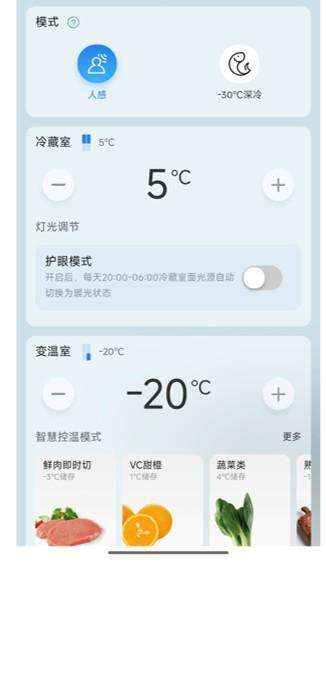


- **系统启动慢**：同理，将数据全部保存在内存当中，会导致每次系统重启都需要把所有的文档重新入库，对于文档数量很大的场景，每次都要花费大量的时间完成文档入库，这对系统的启动性能无疑是灾难性的。
- **资源占用率高**：在用户问答阶段，每次仅需要用到极少量的切片和向量数据，将所有数据存在内存中会造成大量的资源浪费，甚至影响系统性能。

## 1.2 使用持久化存储提升系统性能

既然将所有数据存储在内存当中会引发这么多问题，那么是否将其放在外部存储呢？答案是肯定的。在RAG系统中，通常会借助**向量数据库**将向量数据、切片内容以及一些元数据存储在外部存储介质（如硬盘）当中，以实现数据的持久化存储和高效检索。

相比使用内存这种易失性存储介质，持久化存储用于RAG系统中的具体优势如下：


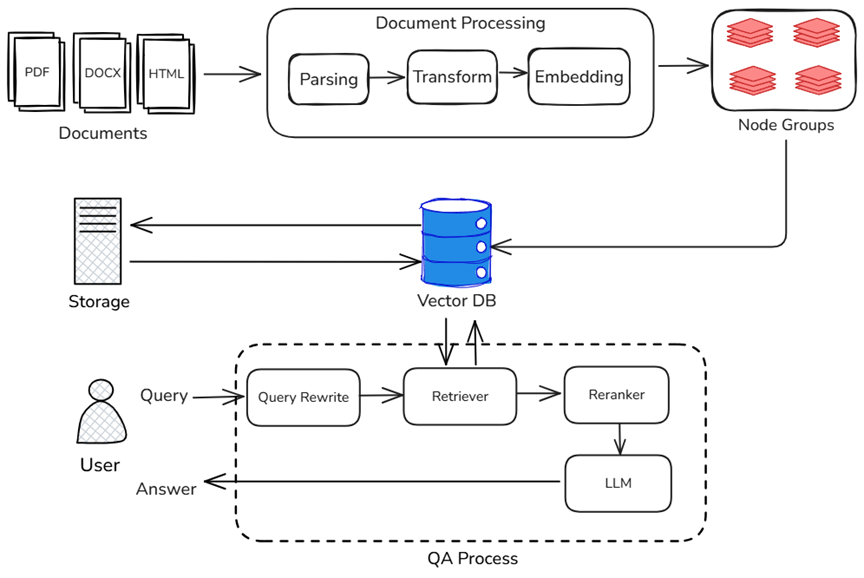


- **减少重复计算**：通过持久化存储，系统可以直接从硬盘当中加载已存储的向量数据，避免了每次启动 RAG 系统时，都需要重新对所有文档进行向量化，大幅减少启动时的计算负担；
- **提高内存利用率**：由于多数向量在检索阶段之外很少被访问，因此长期占用内存是不必要的，通过持久化存储，可以将向量数据从内存中释放，仅在检索时加载相关向量，从而提高内存利用率；
- **提升查询一致性**：如果每次启动系统都重新计算向量，可能会因模型更新、随机初始化等因素导致检索结果的不一致。通过向量数据库持久化存储，可以保证检索结果的稳定性，提高系统的可靠性。


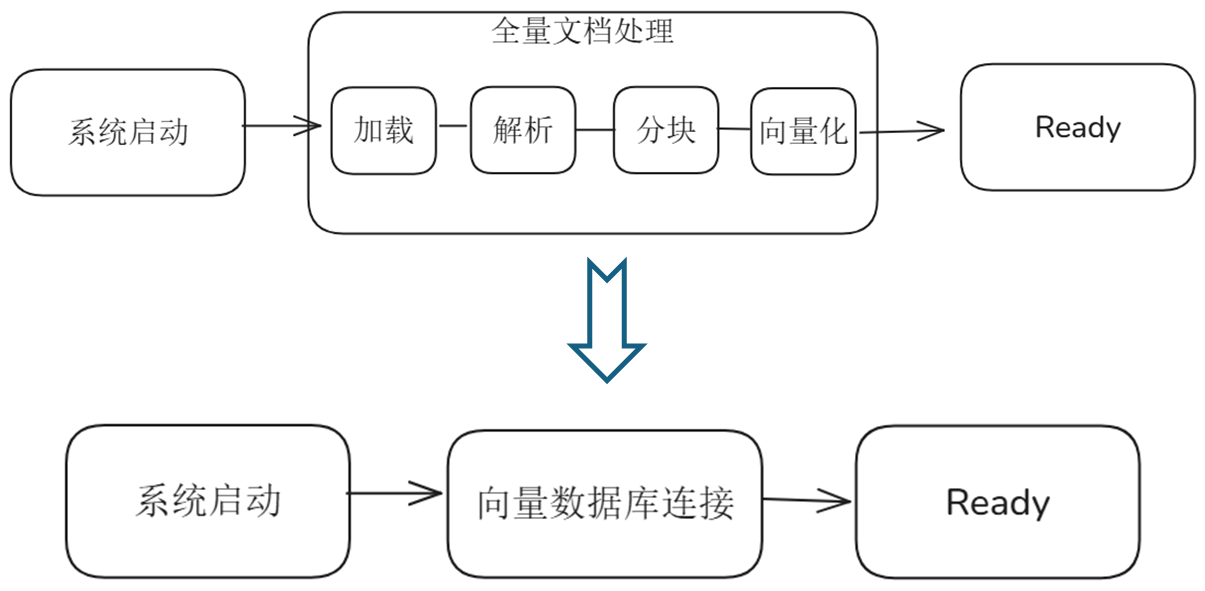


从上述的流程图中，可以看到使用持久化存储后，RAG系统启动流程的变化：

- 原先：系统启动-->全量文档加载（文档解析、分块、向量化）-->启动完毕
- 现在：系统启动-->连接向量数据库-->数据库连接成功，启动完毕

因此，RAG系统中使用持久化存储来保存文档切片、嵌入向量等数据，能够减少系统在二次启动时的数据加载、解析和索引构建时间，避免每次启动都重新运行所有数据加载流程，从而增强系统的稳定性及数据的可复用性，从根本上解决RAG系统启动慢的问题，以更好地适应复杂多变的业务需求。

## 1.3 LazyLLM对于持久化存储的支持

LazyLLM同时提供基于内存和向量数据库两种存储方式以供开发者灵活选择。处于技术探索阶段的开发者，可以直接使用LazyLLM RAG教程中默认的搭建方式，系统将默认采用MapStore，将文档处理后的切片与向量一并保存在内存中，以实现从文档入库至向量检索的最快读写速度；对于处于成熟阶段的RAG系统，LazyLLM提供了多种向量数据库支持，确保数据持久稳定存储，并显著缩短RAG 系统的二次启动时间，提高系统的稳定性和可扩展性。

目前，已有多种成熟的向量数据库解决方案，如开源向量数据库 Chroma、Milvus等。此外，Facebook AI 提供的 FAISS 库也可用于高效向量检索，并能与持久化存储系统结合使用。其中开源向量数据库中常用的 **Chroma适用于小型数据存储和快速原型开发**，提供简单易用的 API，支持文本嵌入存储和相似度检索。而 **Milvus 则适用于大规模数据场景**，可支持 PB 级数据存储，支持分布式部署，能够满足企业级应用的需求。此外 Milvus 提供多种索引方法，可根据不同需求在查询速度和检索精度之间进行权衡。

在上述主流的向量数据库中，LazyLLM选择了Chroma和Milvus进行了深度适配，无论是小规模实验还是企业级应用场景，都能帮助开发者顺利完成复合场景需求的向量数据库接入，以帮助开发者实现从项目初期的快速验证到项目落地的稳定运行的良好闭环。

- **轻量级实验**：在项目早期，开发者可使用LazyLLM中的ChromadbStore快速完成 PoC（Proof of Concept）验证，缩短从构思到可运行原型的周期。
- **企业级部署**：当数据体量增长或对可扩展性、可靠性提出更高要求时，使用LazyLLM中的MilvusStore即可将Milvus平滑接入RAG系统，充分利用其分布式架构与多索引策略，实现高并发、高吞吐的向量检索服务。

| 组件名        | 存储介质 | 功能描述                                                     | 适用场景                                                     |
| ------------- | -------- | ------------------------------------------------------------ | ------------------------------------------------------------ |
| MapStore      | 内存     | 基于内存的存储，提供节点存储的基本能力，能以最快的速度实现数据读写 | 技术探索阶段，将少量文档处理数据保存在内存中，以技术选型与算法迭代的快速验证 |
| ChromadbStore | 硬盘     | 使用 Chroma向量数据库，实现数据的持久化存储。                | 轻量级实验，快速POC，缩短从构思到可运行原型的研发周期        |
| MilvusStore   | 硬盘     | 使用Milvus向量数据库，实现数据的本地存储/分布式远程存储。    | 企业级部署，适用于数据体量大，对并发、检索性能都有较高要求的场景 |

持久化存储提升启动效率 - LazyLLM

documents = lazyllm.Document(dataset_path="xxx", embed=xxx, …, store_conf={…})


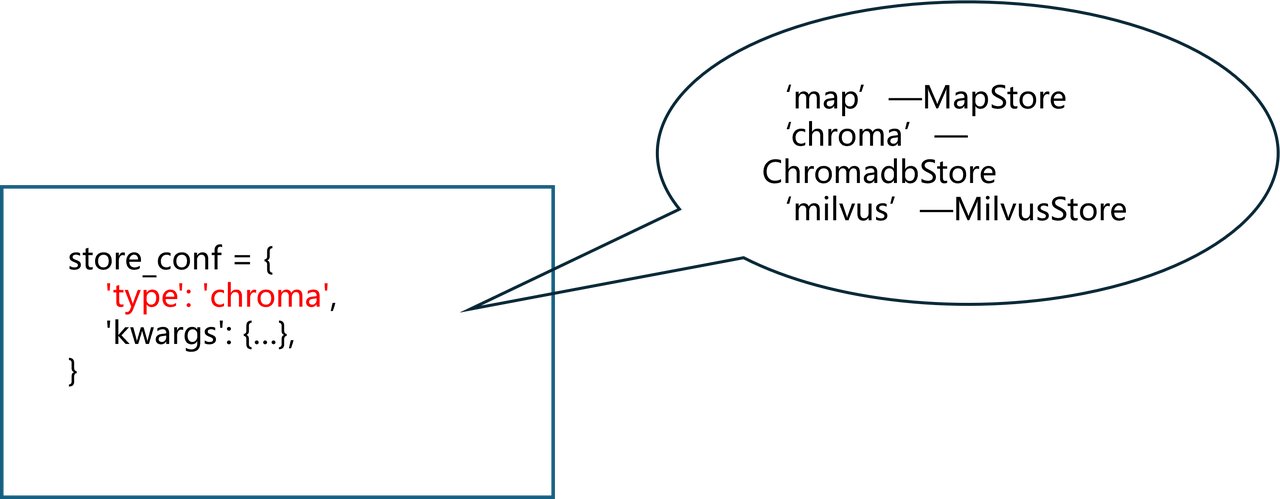


## 1.4 扩展学习（可选）

​      程序运行主要涉及三大核心组件：CPU、内存和外部存储（如硬盘）。

·程序从硬盘加载至内存并运行

·CPU从内存中读取程序指令并执行

·数据读取：CPU请求操作系统访问硬盘，数据从硬盘加载至内存

·数据写入：CPU先将数据写入内存，最终由操作系统写入硬盘，以实现持久化存储


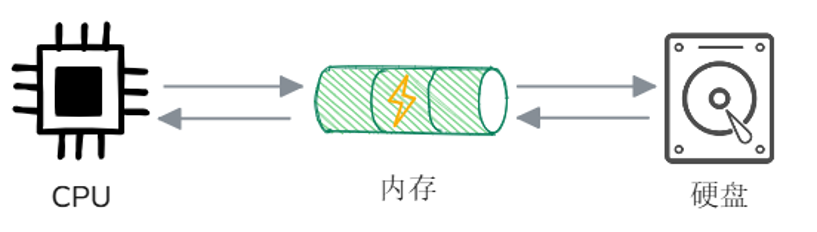


### 1.4.1 内存与硬盘

内存（Memory，通常指 RAM）和硬盘（Storage，通常指 SSD/HDD）是计算机中两种主要存储介质，各自承担不同的角色与功能。

**内存**是一种计算机中的临时存储设备，主要用于CPU和硬盘之间的数据交换，它是计算机执行程序和处理数据时的临时工作空间。内存具有以下特性：

- **高速访问**： 内存具有极快的读写速度，通常以纳秒（ns）计，CPU可以快速访问并处理内存中的数据。
- **易失性**： 内存中的数据在断电或重启计算机时会全部丢失，因此称为“易失性存储”。
- **容量相对较小**： 目前常见的计算机内存容量一般在几GB到几百GB之间。
- **随机访问能力**： CPU可以以任意顺序、同等速度访问内存中的任意位置数据。

**硬盘**是计算机的持久性存储设备，用于长期保存程序、数据和文件。即使计算机关机，硬盘上的数据也不会丢失。硬盘通常有以下特性：

- **持久存储**： 数据一旦写入硬盘，即使断电也不会丢失，能够长期保存数据。
- **容量大**： 相较内存，硬盘具有更大的存储容量，通常从几百GB到数TB甚至数十TB。
- **访问速度较慢**： 传统机械硬盘（HDD）访问数据时通常有毫秒级延迟，而固态硬盘（SSD）则快得多，但整体速度仍远低于内存。
- **数据访问方式**：
  - **机械硬盘（HDD）**：通过磁头寻道、转盘旋转完成数据访问，存在寻道延迟。
  - **固态硬盘（SSD）**：采用闪存技术，无机械部件，访问速度更快，更稳定、可靠。

| 特性         | 内存（RAM）                  | 硬盘（HDD/SSD）                    |
| ------------ | ---------------------------- | ---------------------------------- |
| 存储时效性   | 易失性，断电数据丢失         | 持久性，断电数据不丢失             |
| 存储容量     | 较小（数GB至数百GB）         | 较大（数百GB至数十TB）             |
| 数据访问速度 | 极快（纳秒级）               | 较慢（毫秒级HDD，微秒级SSD）       |
| 价格         | 单位容量价格昂贵             | 单位容量价格相对便宜               |
| 用途         | 临时存储，程序运行时数据暂存 | 长期存储，数据、程序和系统持久保存 |

表：内存与硬盘特性差异

内存与硬盘在速度和特性上有显著差异。就访问速度而言，内存的读写延迟以纳秒为单位，而机械硬盘的寻道延迟通常以毫秒计，内存访问速度比机械硬盘快**约10万倍**，比SSD快**约1500倍**，这意味着**从内存获取数据几乎是即时的**，而从硬盘读取可能要等待数毫秒甚至更久，极速访问能力让基于内存的文档入库及信息检索成为对实时性要求高的应用的首选。然而，内存虽然速度快，但属于**易失性资源**，断电或重启后数据会丢失；相比之下，硬盘（如 SSD）具备数据持久性与容量优势，更适合作为长期存储媒介。

虽然硬盘与内存在速度上相差甚远，但近年来，硬盘技术从传统的机械硬盘（HDD） 到 SATA 接口的固态硬盘（SSD），再到高速 NVMe SSD，性能不断提升，主要体现在**随机访问延迟**和**数据吞吐量**两方面。HDD 使用机械旋转碟片和磁头寻道，平均寻址延迟在毫秒级别（典型7200转 HDD 延迟 4.17ms）；而SSD没有机械部件，依赖电子存储单元，SATA SSD 的读写延迟可低至几十微秒（如 Intel 企业级 SATA SSD 延迟 0.036ms），NVMe SSD（尤其是采用高速总线的 Optane 类存储）延迟甚至可达到 5µs（0.005ms)。除此之外，不同介质的I/O 吞吐能力差异也很大：HDD 每秒处理的随机 I/O 操作（IOPS）上限仅几百次，而 SATA SSD 可达数万次，NVMe SSD 则轻松上百万次。下表比较了这些存储介质的典型性能指标：

| 存储介质     | 平均延迟 (Random Latency) | 随机 IOPS | 顺序吞吐量 (Seq. Read) |
| ------------ | ------------------------- | --------- | ---------------------- |
| HDD (7200转) | 4.2 ms                    | 400       | 150 MB/s               |
| SATA SSD     | 0.036 ms                  | 97,000    | 600 MB/s               |
| NVMe SSD     | 0.005 ms                  | 1,500,000 | 7200 MB/s              |

如上所示，SSD 尤其是 NVMe SSD 相比 HDD 在**随机读写**性能上有数量级的提升，即使在顺序读写场景下，NVMe SSD 也能达到数GB每秒的吞吐，是机械硬盘的几十倍，这意味着如果将大规模文本切片及向量数据存储在 SSD ，可以显著减少I/O瓶颈，提升RAG系统的整体响应速度。当然这种提升**以更高的成本为代价**，因此在实际部署中需要在容量、性能与成本之间权衡。


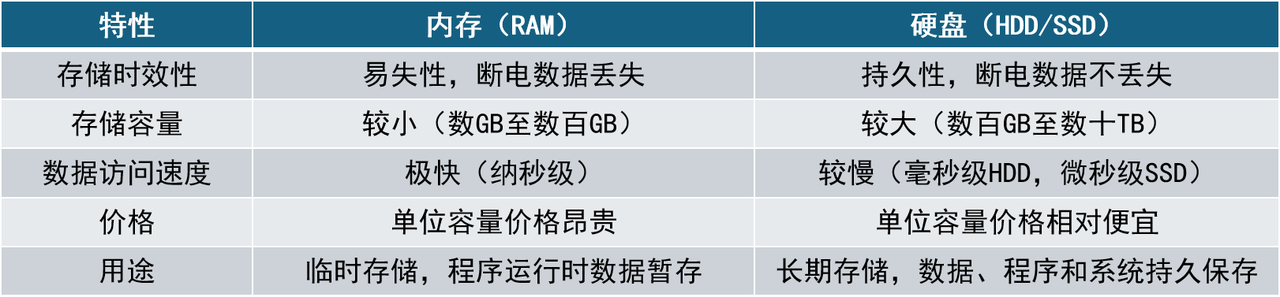


极速访问能力让基于内存的文档入库及信息检索成为对实时性要求高的应用的首选，也是我们在前面的教程中将数据全部加载至内存的原因。在RAG 系统的开发初期，由于技术选型（比如Embedding模型、Reader）及系统设计（比如分块策略、节点组设计）暂未确定，研发过程中存在频繁的技术迭代，相比海量文档处理数据的稳定存储，开发者们往往更倾向于选择少量典型文档，结合先进的算法及工程优化技术，验证系统的实际表现。因此，将文本切片、向量嵌入等数据暂存于内存中进行检索，能够以最快的速度获取查询响应。

然而，正如上文的内存特性介绍，它是”易失“的，一旦服务进程重启或机器宕机，先前保存在内存中的文档切片、向量索引就会消失，下次运行程序便又是“从头再来”，因此**内存存储只适合加速开发和小规模实验**。随着系统设计及算法优化逐步走向稳定，海量的正式文档便需要进行入库检索，这个阶段谁也不希望每次运行程序都要花费大量时间等待文档重新入库，因此我们通常需要将这些数据保存至硬盘中。

### 1.4.2 内存缓存机制：预存高热数据加速系统响应

对于一个高性能系统来说，对于内存和硬盘的选择永远不是OR，而是AND。针对磁盘相对内存较慢的劣势，实际系统架构中常引入**缓存层**，利用内存缓存弥补磁盘速度差异。内存缓存（Memory Cache）机制是一种通过预存储高频访问数据来减少重复计算和外部检索的优化策略，合理使用缓存机制可显著提升系统响应速度并降低资源消耗。

在RAG场景下，通常将“热点”数据缓存在内存中，比如经常查询的向量或检索结果，以便后续相似查询可以直接从内存获取这些数据，从而减少重复计算和磁盘I/O，从而最大程度上弥补磁盘存储的性能差距，让RAG检索既兼顾持久化又不失速度。我们假设一个检索系统中，用户频繁问“北京有多少地铁站？”，第一次处理时，系统请求数据库检索时，数据库会将相关的嵌入向量和切片数据从硬盘中读取并回答，耗时较长；随后系统将结果缓存起来，下一次问这个问题时，**直接从内存中返回相关内容**，大大提升了系统的响应速度。


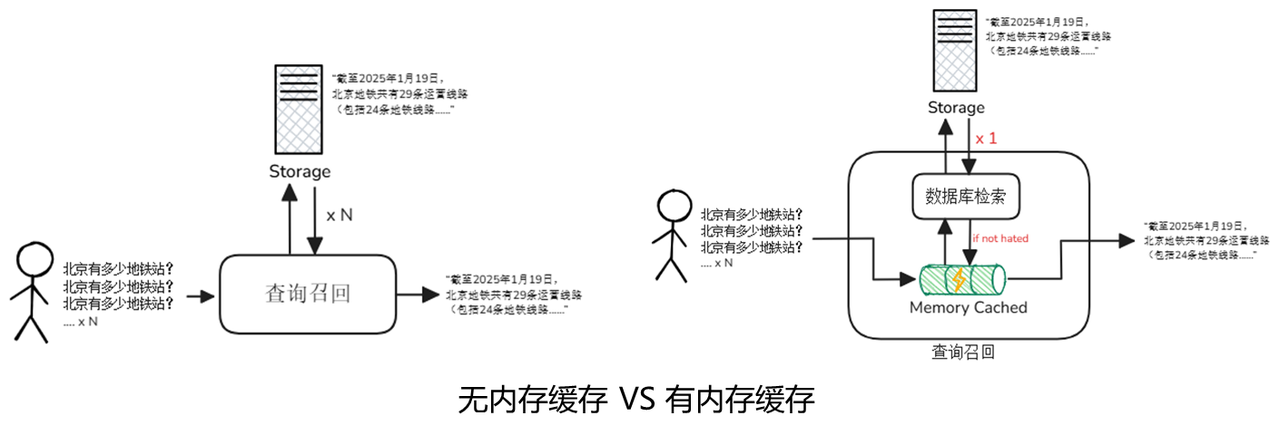


在现代计算系统中，内存缓存机制是一种通过预存储高频访问数据来减少重复计算的优化策略。它通过“用内存换时间”的方式，显著提升了系统响应速度，同时降低了底层存储和计算资源的消耗。内存缓存机制的实现通常依赖高性能的内存缓存系统，其中最为常用的两种解决方案是 Redis 和 Memcached。它们各具特色，适用于不同的应用场景。

Redis 是目前最广泛使用的内存缓存系统之一。它不仅支持简单的 key-value 缓存，还内置了丰富的数据结构，如列表（List）、集合（Set）、有序集合（Zset）、哈希表（Hash）等，能够满足各种结构化与半结构化数据的缓存需求。以下是 Redis 的核心特性和典型应用场景：

核心特性：

多数据结构支持：Redis 提供多种数据结构，方便处理复杂的数据关系。

TTL（过期时间）：支持灵活设置缓存的生命周期，通过 TTL 自动清理过期数据。

持久化机制：支持 RDB（快照）和 AOF（日志追加）两种持久化方式，即使在内存丢失后也能恢复数据。

Lua 脚本：内置 Lua 脚本支持，适合实现复杂的原子操作。

典型用法：

热向量缓存：在 RAG（Retrieval-Augmented Generation）系统中，Redis 可以用于缓存高频访问的向量化数据，减少检索计算开销。

会话上下文管理：在对话系统中，Redis 可缓存用户的会话历史，提供上下文关联能力。

排行榜：借助有序集合（Zset），Redis 可轻松实现排行榜功能。

相比 Redis，Memcached 是一种更加轻量级的内存缓存方案，专注于“高速 key-value 读写”。它以极简的设计和高性能著称，适合缓存短生命周期、访问频率高但结构简单的数据。

核心特性：

纯内存存储：Memcached 不支持持久化，数据完全存储在内存中，掉电即失。

简单协议：支持简单高效的文本协议，减少了通信开销。

超低延迟：读写延迟可达到微秒级，适合需要极致性能的场景。

典型用法：

模型参数缓存：在机器学习或深度学习系统中，Memcached 可用来缓存频繁使用的模型参数，降低计算成本。

Session 缓存：用于存储用户的临时会话信息，支持高并发访问。

HTML 片段缓存：在 Web 应用中，Memcached 可缓存动态渲染的 HTML 片段，提升页面加载速度。

虽然 Redis 和 Memcached 在功能上存在差异，但它们都以“用内存换时间”的方式，有效提升了数据访问速度。在 RAG 系统中，合理地引入内存缓存机制，不仅能提升单次查询性能，还能显著降低底层数据库的压力，使整个问答流程在保证准确性的前提下更加轻盈与高效。

### 1.4.3 标量数据库与向量数据库

对于存储硬盘中的文档、切片和向量等数据，系统通常使用数据库进行增删改查操作。数据库（Database）是一种用于有组织地存储、管理、检索和操作数据的软件系统，具有高效存储、高效访问、支持并发与一致性的特点。按照存储数据的类型，数据库可以分为**标量数据库**和**向量数据库**。

标量数据库，也就是我们日常最常接触的传统数据库，比如 MySQL、PostgreSQL、MongoDB 等。它们主要处理结构化数据，也就是那种字段比较清晰的表格状信息，例如用户的姓名、性别、出生日期，订单的时间、价格、状态等等。标量数据库擅长做精确查询、聚合分析、事务处理等任务，广泛应用在金融、审计、医疗、供应链等领域。以 PostgreSQL 为例，它支持复杂的 SQL 语句、全文搜索、JSON 结构，还能配合地理信息做空间查询，非常适合搭建中大型企业的业务系统。


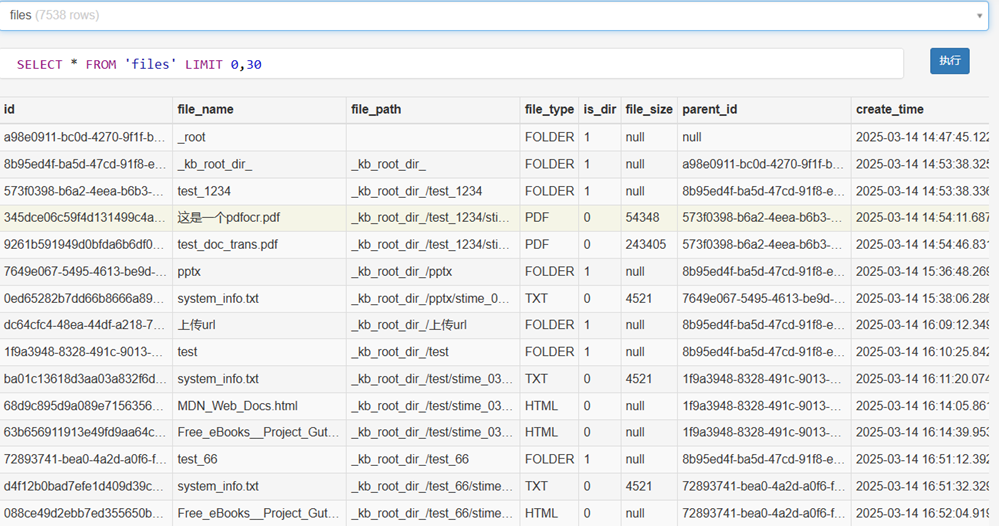


向量数据库是随着 AI 兴起而被大量使用的新型数据库，主要面向非结构化数据的**特征向量存储**和**相似度检索任务**，比如文本向量、图像向量等。这些数据通常是通过大模型编码得到的高维浮点数数组，传统数据库并不擅长管理这类数据。向量数据库专门提供了高效的向量索引结构（比如 HNSW、IVF、PQ），可以大规模数据的高效检索（有关向量索引的内容将在下一节介绍）。同时一些向量数据库也支持向量+元数据的混合过滤，方便做基于语义理解的检索、推荐与多模态问答。

目前较为主流的向量数据库有 Chroma、Faiss、Milvus。这几款系统在检索性能、部署复杂度、功能丰富度和生态支持上各有特点，适用于不同的业务场景。以下将逐一介绍它们的定位与特点。


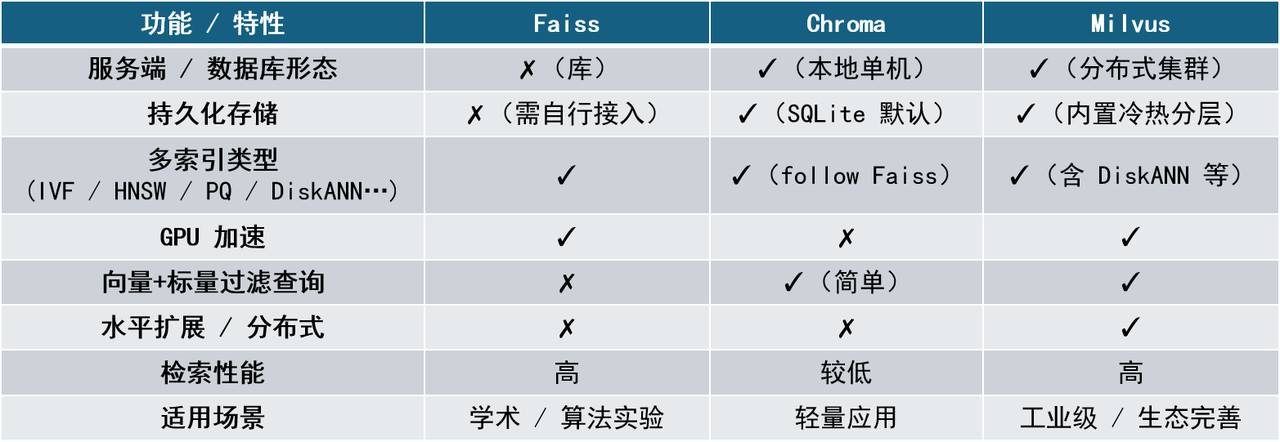


- Faiss
  -  Faiss 是 Facebook AI 开源的一款**高性能向量搜索库**，核心优势在于其极致优化的 C++ 实现和强大的索引支持。Faiss 并不是一个数据库，而是一个“工具库”，提供一系列向量索引算法的实现，包括 Flat、IVF、PQ、HNSW 等。Faiss 的定位更偏底层，通常被用于构建自定义向量系统，适合有能力自行封装服务、管理存储和持久化的团队或开发者。
- Chroma
  -  Chroma 是一款定位于**轻量级、本地化、快速部署**的向量数据库，主打“开箱即用”的用户体验。它将“文档+元数据+嵌入向量”三者紧密绑定在一起，默认采用 SQLite 存储和 FAISS 作为索引引擎，支持简单的过滤和按 namespace 分隔数据。Chroma 适合小型项目或原型系统的快速开发，尤其适用于个人开发者、本地测试、教育场景。但它在分布式部署、索引类型灵活性、大规模检索优化等方面仍有明显短板。
- Milvus
  -  Milvus 是一款功能完备的向量数据库，由 Zilliz 开发，目标是构建“工业级向量检索系统”。它具备完整的向量生命周期管理能力，支持百万级甚至十亿级的向量存储与检索，适合部署在云端、服务器集群等生产环境中。Milvus 的架构支持分布式部署、冷热分层存储、向量+标量混合过滤查询，并提供 SDK 与 RESTful/gRPC 接口。

| 名称   | 主要特性                                                     | 优劣势                                                       | 适用场景                                         |
| ------ | ------------------------------------------------------------ | ------------------------------------------------------------ | ------------------------------------------------ |
| Faiss  | 支持多种高效向量索引算法（包括 GPU 加速版本）精度与速度可以通过配置灵活权衡提供 Python/C++ 接口 | **优势**：性能极高，适合大规模向量搜索支持索引压缩与 GPU 加速可完全自定义控制存储结构与索引更新逻辑**劣势**：不包含服务端功能，无原生持久化、元数据管理能力部署需要额外封装或接入外部组件（如 SQLite、Redis） | 嵌入式场景、定制化搜索系统、模型评估或研究项目   |
| Chroma | 内置嵌入生成模块（支持OpenAI、Instructor等）本地部署友好，支持 Python 调用和 REST API支持向量检索与元数据过滤不支持复杂索引结构，查询效率受限于 FAISS 的默认配置 | **优势**：无需依赖后端服务，部署极其简单与多种大模型应用开发框架工具集成良好社区活跃，开发迭代快**劣势**：查询效率一般，索引能力受限不支持分布式，不适合大规模向量存储与高并发场景 | 小型应用、本地文档问答、教育演示、RAG入门实验    |
| Milvus | 多种 ANN 索引（HNSW、IVF、DISKANN）元数据过滤、布尔筛选、多字段组合查询支持分布式、水平扩展、冷热分离存储接口丰富，支持 Python、Java、Go 等调用 | **优势**：**功能性**：不仅支持基本的向量相似性搜索，还支持稀疏向量、批量向量、过滤搜索和混合搜索功能等高级功能。**灵活性**：支持多种部署模式和多个 SDK，所有这些都在一个强大的集成生态系统中实现。**性能**：采用HNSW和DiskANN 等优化索引算法以及先进的GPU 加速，可确保高吞吐量和低延迟的实时处理。**可扩展性**：其定制的分布式架构可轻松扩展，从小型数据集到超过 100 亿向量的 Collections 都能轻松应对。**劣势**：架构复杂，部署门槛较高，可能需要较多调优与配置 | 企业级文档搜索、图像搜索、推荐系统、RAG 服务部署 |



# 二、高效索引构建及向量检索算法

## 2.1 索引

###  2.1.1 索引简介

索引（Index）是一种特殊的数据结构，其的作用是通过预先组织数据的结构，使检索器能够高效定位和检索相关信息。简单来说，索引就像是书籍中的目录，它帮助快速定位特定信息，**避免逐页查找**。不妨想象一下，假如没有索引，检索器就必须顺序扫描书中的每一页，逐字逐句地寻找与查询相关的内容，这个过程被称为**线性搜索**（Linear Search），线性搜索的时间复杂度是 O(n)，n 是文档的数量或文档的总字数。随着数据量的增大，线性搜索会变得极其低效。通过构建索引，可以将文档中的信息组织成高效的数据结构，使得查询时能直接访问相关数据，时间复杂度通常能降到 **O(log n)** 或更低，可以极大提升检索效率。


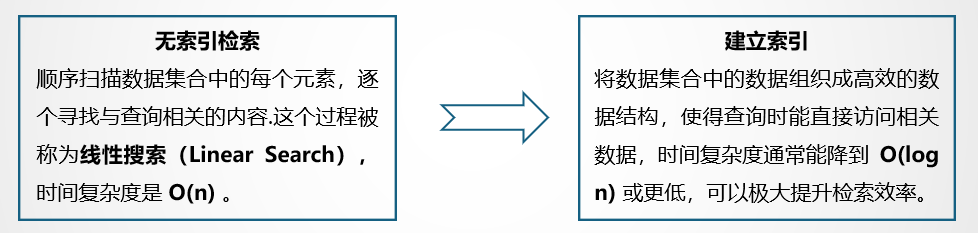


下图以查词典为例，展示了有无索引对于搜索过程的影响。假设有一个词典，每个字母开头的单词有N个，那么这个词典总共有 26*N 个单词。我们的目标是从词典中查找“retrieve”这个单词，图中左侧展示了利用线性查找方法，从 a 开头的单词逐个查找，r 是字母表中的第 18 个字母，找到 ”retrieve“ 这个单词需要进行（17N+i）次查询，（假设 “retireve” 是以 r 开头的单词中第 i 个单词）；图片右侧展示了使用字典树索引的查找方法，只需要（18+5+20+18+9+5+22+5=102）次，其中 18 为 r 在 26 个字母中的序号，5 为 e 的序号，以此类推。如果N=100，二者的查询次数分别是(1700+i) vs 102，1<=i<=100，N越大，计算量差距越大，计算效率孰高孰低，清晰可见。


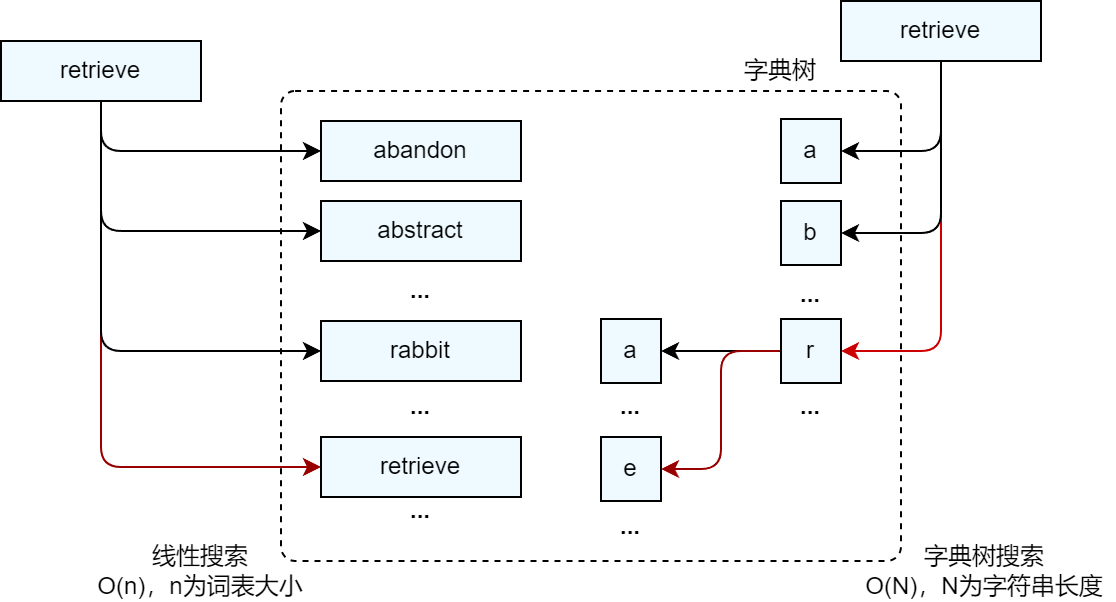


实际上，利用字典树对任意单词进行查询时最多只需要进行（26*m）次查询，其中m是被查询单词的长度，也就是可以将查询复杂度降低到**O(m)**。通过上述例子，我们可以感受到使用索引能够大幅减少检索过程中的计算次数，提升检索效率。

**标量索引**：

标量索引即在传统关系型数据库中针对标量列值（如数字、字符串、布尔值、日期等）建立的数据结构，以帮助数据库高效查找数据。

标量索引主要有以下四个作用：

·显著提升查询速度:帮助数据库直接定位到数据文件中的目标位置，从而有效避免了全表扫描这种耗时的操作。 

·降低磁盘I/O次数：使数据库无需对整个数据集进行读取，这极大地减轻了磁盘 I/O 的负担。

·优化排序与分组操作：使服务器避免进行排序和使用临时表的情况，进而提高查询效率。

·提升复杂查询的性能：能够对复杂的查询操作提供高效支持，比如在进行表连接操作，或者查找最大值、最小值等操作时。

**向量索引**：

向量索引是用于加速高维向量数据相似度检索的索引结构，它的目标是在大规模数据集中，快速找到与某个查询向量最相似（Top-K）的若干个向量。


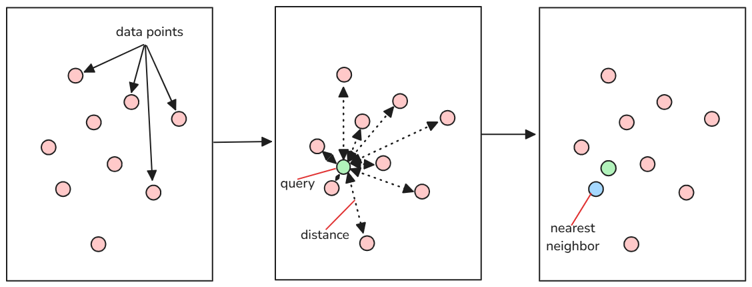


RAG系统中的向量检索可以描述为“给定查询向量 q，在向量集合 V 中找到距离（或相似度）最小（或最大）的若干个向量。”这一过程被称之为最近邻搜索（Nearest Neighbor, NN），当检索参数中存在Top K时，即需要查找与目标数据最相似的前K个数据项时，上述搜搜过程便演化为K最近邻搜索(K-Nearest Neighbor，K-NN）

问题暴露：向量规模变大，计算量暴增

### 2.1.2 LazyLLM中的索引

在先前的课程中，我们了解到通过多节点组（node group）结合不同的相似度（similarity）计算方法能够有效提升RAG系统的召回效果。同样，LazyLLM内置了默认索引DefautIndex和向量索引SmartEmbeddingIndex，并提供了索引组件（IndexBase）以支持自定义索引设计，只需要简单定义三个函数（update插入节点，remove删除节点，query查询节点），即可快速实现灵活索引。

从框架设计而言，LazyLLM各组件层次清晰，分工明确，相比其他主流的应用开发框架有着更高的可读性和可扩展性。以下是另一主流应用开发框架Llamaindex中索引（Index）组件的概况。

Llamaindex中的索引组件基类为IndexBase，其中定义了数十个入参及方法以供其他子类实现多种复杂功能。在Llamaindex的索引定义中，其接收一组节点集合后，**无法直接查询**，而是需要结合内置方法as_retriever、as_query_engine等，把Index转换为检索器或查询引擎，从而调用检索器或查询引擎中对应的查询方法进行检索。这种设计使得开发者阅读其源码的时候感受很怪——**明明是索引，却在给入节点集合后无法直接使用其检索**，反而内置了很多转来转去的方法“绕弯子”。同时，虽然其内置的很多“Index类型”，但很多都不在“索引”范畴当中，概念相当混乱。以下是针对其中的一些典型index，梳理至LazyLLM的概念框架中后的表格呈现。

| Index type           | description                                                  | node group | similarity                                                   | index        |
| -------------------- | ------------------------------------------------------------ | ---------- | ------------------------------------------------------------ | ------------ |
| SummaryIndex         | 一个简单的数据结构，它将文档存储为节点序列。在索引构建期间，文档文本被分块、转换为节点并存储在一个列表中。用于检索包含特定关键字或短语的文档。 | X          | none（什么都不干，全量返回节点集合）llm(模型从集合中选择相似节点)cosine | X            |
| VectorStoreIndex     | 向量索引，存入的过程当中会调用embedding模型将文本向量化      | X          | cosine                                                       | vector index |
| DocumentSummaryIndex | 使用大模型提取文档总结并建立索引                             | summary    | llm/cosine                                                   | X            |
| KeywordTableIndex    | 使用大模型提取文档片段的关键词，建立关键词索引               | X          | llm提取                                                      | linear       |

可以看出，一些典型的Index，并没有单一的清晰概念，而是通过各种配置参数实现了很多概念混杂的功能。相比之下，在LazyLLM的定义中，将文件按照规则切分（Transform）为节点组（Node group）并建立索引（Index），随后使用检索器（Retriever）根据特定的相似度类型（similarity）获取与目标数据最相似的数据集合，这个流程和定义显得异常清新。

## 2.2 高效的向量数据库

对于开发者来说，从零开始写一个向量索引算法以实现高效检索绝对不是我们想要的。而向量索引恰恰是向量数据库的核心能力之一，我们可以简单认为：

**向量数据库 =** **向量索引** **+** **向量存储** **+** **API支持** **+** **元数据管理**

高效的索引算法被整合在各大主流的向量数据库当中，系统写入向量至数据库后，向量数据库可以在查询时利用向量索引快速定位最相似的几个向量，大大提升响应速度。

在LazyLLM的设计中，可以通过Document的**store_conf**参数实现向量数据库的灵活配置，其中的'type'字段指定了具体的数据库类型。我们在使用LazyLLM搭建RAG系统时，只需在Document中给定存储配置项store_conf，在其中写入对应的向量数据库类型以及数据库相关配置（如本地存储路径、使用的索引类型等），即可实现向量数据库的接入。另外，对于Milvus向量数据库，LazyLLM原生支持其独特的**标量索引**功能，在检索环节传入filter字段，无需手动过滤，即依照标量索引进行节点筛选，以实现向量+标量的复杂检索。


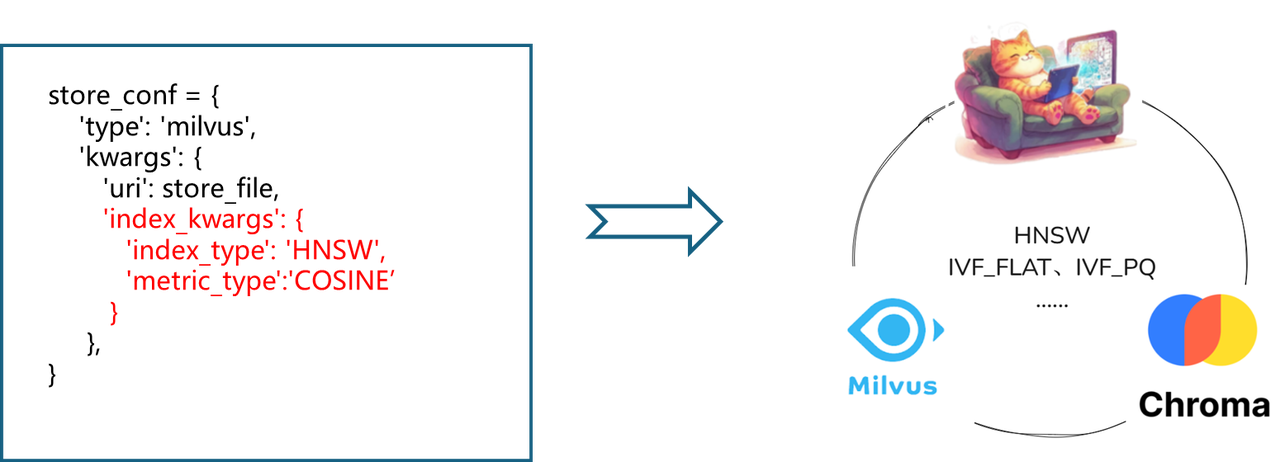


## 2.3 工程优化：性能提升的“隐形推手”

在讨论 RAG 系统的性能优化时，我们往往将注意力集中在算法优化和技术选型选择上，例如使用更高效的索引结构、更优的召回策略、更合适的向量数据库等。然而，影响RAG系统性能的不止算法和数据库本身。**工程层面的优化，往往是决定系统能否稳定、高效落地的关键所在**。

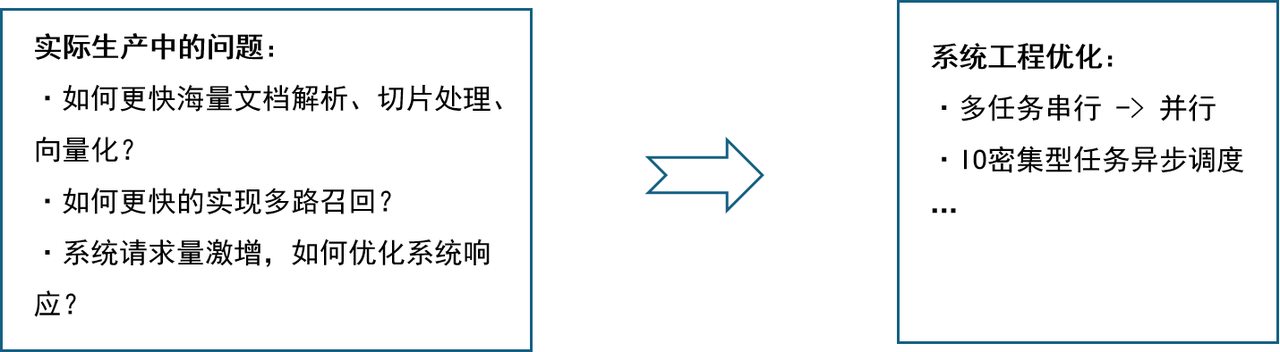

在工程领域，我们通常将任务分为两大类：

- **IO密集型任务**：主要瓶颈在于磁盘读写、网络传输、数据库访问等输入/输出操作，这类任务处理速度受限于外部设备的响应时间。 典型场景：文件传输、调用远程 API 等。
- **计算密集型任务**：主要瓶颈在于自身的运算量，依赖 CPU 或 GPU 进行大量数学计算。 典型场景：本地模型推理、数据分析等。

### 并行和并发

并行处理（Parallel Processing）是计算机系统中能**同时执行两个或更多个处理**的一种计算方法。可同时工作于同一程序的不同方面。主要目的是节省大型和复杂问题的解决时间。

并发处理(Concurrency Processing)：指一个时间段中有几个程序都处于已启动运行到运行完毕之间，且这几个程序都是在同一个CPU上运行，但**任一个时刻点上只有一个程序在CPU上运行**。

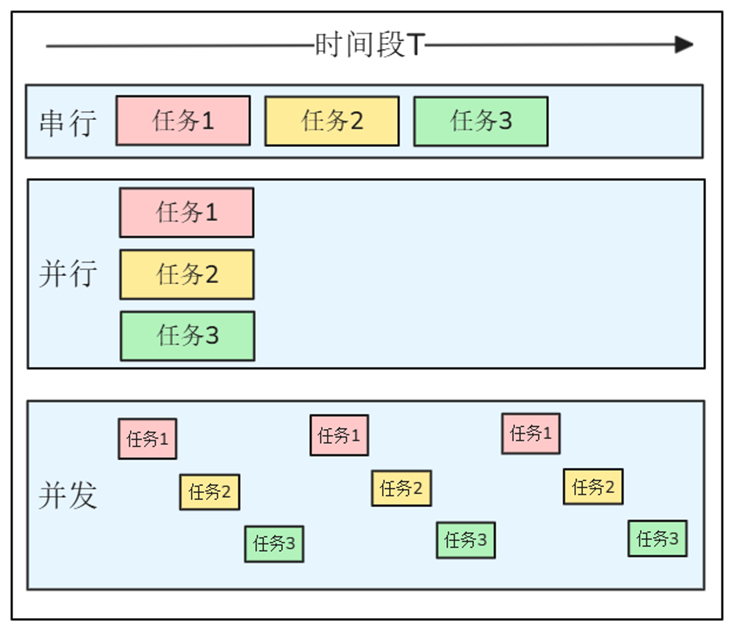

- 生活中：饭店中的厨师
  - 串行：一名厨师先洗菜→再炒菜→再煮汤→最后蒸饭
  - 并行：三个厨师分别负责炒菜、煮汤、蒸饭→同时进行，互不影响
  - 并发：一名厨师多个灶台，把菜丢下锅后等待3min，这3min去炖汤，期间回来翻炒、调味、装盘
- 程序中：文档解析
  - 串行：海量文档逐个解析
  - 并行：开多个线程，多个文档同时进行解析
  - 并发：同一个线程中，让 文件I/O等待时间“空出来”给别的任务，期间不闲着，去做别的事情

### Python中的并行

Python当中的并行主要用多进程和多线程实现。

- **多线程**（Thread）：在同一进程内部并发执行多个线程；共享进程的内存与资源。
  - 核心特点：
    - **线程切换开销小**，启动快
    - 受 CPython GIL 约束，仅适合 I/O 密集
    - 数据共享简单，但**易出现竞态**；需锁、队列等同步手段
  - Python实现：concurrent.futures中的ThreadPoolExecutor线程池
- **多进程**（Process）：同一程序在操作系统层面复制出多个独立进程；每个进程拥有独立内存空间和Python解释器。
  - 核心特点：
    - 真正多核并行，不受 GIL 限制
    - 进程间通信需IPC（队列、管道、共享内存）
    - 创建与切换成本高，进程启动慢
  - Python实现：使用multiprocessing实现多进程

#### **GIL(全局解释器锁)**

Global Interpreter Lock(GIL，**全局解释器锁**)是一个防止解释器多线程并发执行机器码的一个全局互斥锁，其核心作用是确保同一时刻只有一个线程执行Python字节码。

GIL存在的必然性是以下情况导致的：

- 历史遗留问题：Python早期设计采用引用计数内存管理机制，未考虑多核时代的并发需求
- 线程安全保障：防止多线程同时修改对象引用计数导致内存泄漏(如两个线程同时释放同一对象)
- 生态依赖：大量Python扩展库基于GIL的线程安全假设开发，移除成本极高

绕过GIL的技术方案：

- 多进程并行（ multiprocessing，使用Queue、Value、Array可灵活实现进程间的内存共享）
- 异步编程模型（asyncio实现单线程高并发，适合I/O密集型场景）
- 混合编程扩展（将核心算法用C/C++实现，如NumPy、Pandas等科学计算库）

注意：asyncio的功能是通过叫做event loop的python对象，调度每个task的代码的执行。当一个task被执行时，只有等task主动交回控制权，才会轮到其他task执行。（这一点和threading的并发显著不同）。因为要设计代码去实现子任务和主程序之前的控制器的给来给出，**所以“异步”的代码要比 threading 并发和 multiprocessing 更加复杂和麻烦**。

#### 线程的价值

在工程领域，我们通常将任务分为两大类：

- **计算密集型（CPU密集型）任务**：
  -  指在执行过程中主要涉及到大量计算和处理，如执行复杂的计算、算法或逻辑操作，而涉及到的IO操作相对较少的任务。

  -  典型场景：**本地模型推理、数据分析**等。
- **IO密集型任务**：
  -  指在执行过程中通常需要与外部资源进行交互，大部分时间都花费在**等待输入输出（IO）操作完成**上，实际的计算量相对较小的任务。

  -  典型场景：**读写文件、网络请求、数据库查询**等。

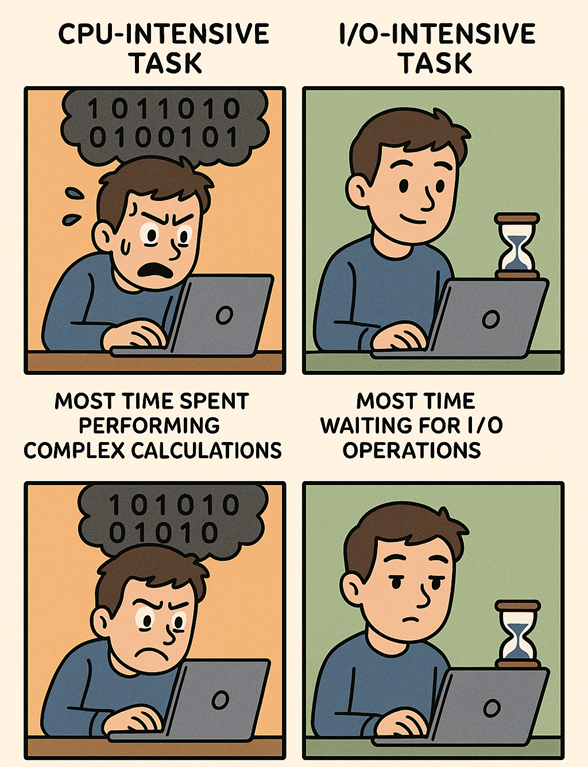

> Python的多线程是为**IO密集型任务**设计的！

### LazyLLM中RAG的性能优化

在 RAG 系统中，IO密集型任务和计算密集型任务广泛存在且交织执行。如果不加以优化，极易出现资源阻塞、处理延迟，甚至引发系统级性能瓶颈。针对RAG场景，LazyLLM在工程优化方面做了很多努力：

- **多线程&异步调度**：LazyLLM原生支持多线程与异步机制。对于IO密集型任务，使用LazyLLM提供的ThreadPoolExecutor，可以充分利用网络传输等待期间的空闲时间，大幅提高资源利用率。同时，LazyLLM的Flow组件中提供了并行组件Parallel、Warp、Diverter，这些组建能够充分利用系统资源，实现数据的并行计算。
- **批处理机制**：在RAG系统中，文档切片向量化环节计算量大、耗时高，针对这一问题，LazyLLM采用了批处理机制，通过将一批切片同时向量化，大幅缩短向量化环节的耗时；同时，对于海量文档解析场景，LazyLLM提供了多进程机制，分批完成文档解析。上述的批处理机制大幅提升了RAG系统在文档入库环节的速度。

RAG 系统性能的提升不仅仅取决于你用了向量索引、选择了哪种向量数据库，更深层次的优化往往来源于你是否在工程实现中做足了功夫。**算法决定上限，工程决定下限**，二者缺一不可。

## 2.4 扩展学习

### **2.4.1 索引的分类**

根据数据存储的类型，索引可以分为**标量索引**和**向量索引**两个类型。

#### **标量索引**

标量索引即在传统的关系型数据库中针对**标量值**（如数字、字符串、布尔值、日期等）建立的索引，以帮助数据库高效获取数据。以MySQL数据库为例，MySQL数据库的索引可以看作数据库表中某一列或多列值的排序列表，通过这个列表，数据库系统可以快速找到复合条件的数据记录，而不需要逐行扫描整个数据表。对于MySQL数据库来说，索引主要有以下四个作用：

- **显著提升查询速度**：索引可以显著提高查询速度，尤其是在数据量较大的情况下。若没有索引，MySQL 在查询时不得不对整个表进行逐行读取，直至找到目标行。但有了索引后，MySQL 能够直接定位到数据文件中的目标位置，从而有效避免了全表扫描这种耗时的操作。
- **降低磁盘I/O次数**：索引能够减少为获取表中某条记录而进行磁盘 I/O 的次数。借助索引，MySQL 可以迅速定位到数据文件中的相应位置，无需对整个数据集进行读取，这极大地减轻了磁盘 I/O 的负担。
- **优化排序与分组操作**：索引有助于服务器避免进行排序和使用临时表的情况，进而提高查询效率。在处理排序和分组相关的查询时，索引可以发挥其独特的优势，优化查询执行过程。
- **提升复杂查询的性能**：索引能够对复杂的查询操作提供支持，比如在进行表连接操作，或者查找最大值、最小值等操作时，索引的存在使得这些复杂查询能够更高效地执行。标量索引主要使用的数据结构有B+树、哈希表、跳表等。

常用的标量索引结构有补充B树/B+树、哈希表和跳表。

**B 树 / B+ 树**

 B 树/B+ 树作为**最流行**的数据库索引数据结构，是一种多叉平衡搜索树，设计初衷是让**一次磁盘 I/O 就能读取整块节点数据**，从而最大化顺序读取、最小化随机寻址；B+ 树是其最常见变体，区别在于**所有数据记录只存放在叶子节点**，内部节点仅保存键值并指向子节点，使得叶子之间形成**有序链表**，范围扫描格外高效。

 **特性**：

- **对数级查询、插入、删除**——所有路径长度相等，复杂度为$O(log \text{mN})$。
- **磁盘亲和**——节点大小通常与磁盘页一致，减少 I/O 次数。
- **天然支持范围查询**——叶子链表顺序遍历可快速得到区间结果。

 B树相对平衡二叉树，在节点空间利用率进行了改进，每个借点存储更多数据，减少了树的高度，提升了查询性能。


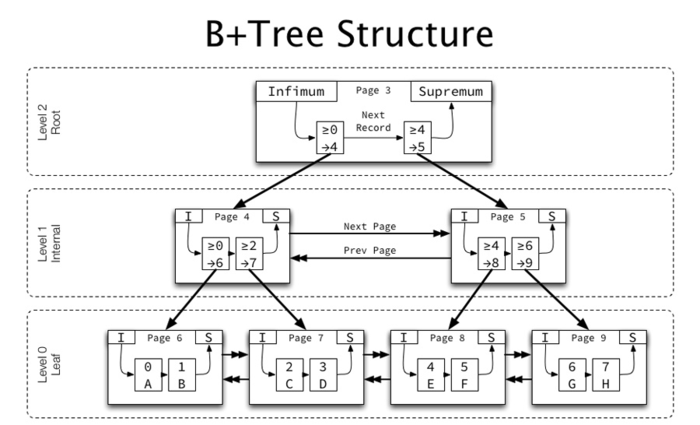



**B树构建**：

定义5阶树，插入数据3、8、31、11、23…

- 节点拆分规则：m=5，关键字数必须小于等于5-1=4
- 排序规则：节点比较 - 左小右大

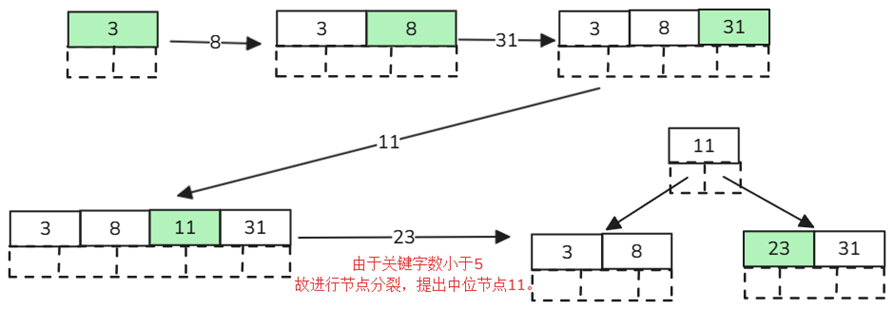

寻找字母“E”：

1. 获取根节点比较，根据二分法左小右大，E<M,所以前往左边子节点查询；
2. 拿到关键字D、G，因D<E<G，所以前往中间子节点查询；
3. 拿到E、F，E=E，所以直接返回关键字和指针信息。

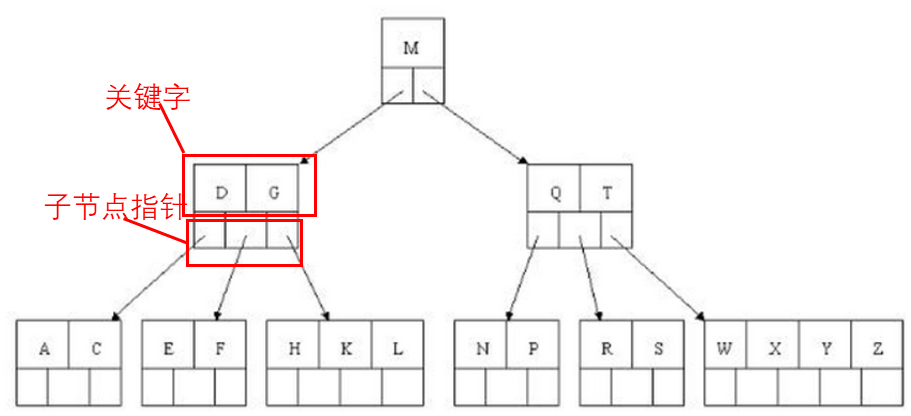

B+树在B树的基础上做了以下改进：

- 非叶子节点不保存具体数据，只保存关键字索引——保证每次数据查询次数一致，提升查询稳定性。
- 叶子节点关键字从小到大有序排列，左边结尾数据会保存右边节点开始数据的指针，对数据排序有着更好的支持。
- 非叶子节点的子节点数=关键字数

**哈希表**

哈希表通过哈希函数 `h(key)` 把键映射到槽位，用链表或开放寻址解决碰撞。它**放弃有序性**，换取几乎常数时间的精确匹配。

 **特性**：

- **平均 O(1) 查询/插入**——只要负载因子受控，速度与数据量无关。
- **实现简单、并发友好**——锁分段或无锁哈希均易于扩展。
- **不支持排序与范围检索**——适合主键、ID、UUID 等精确匹配场景。

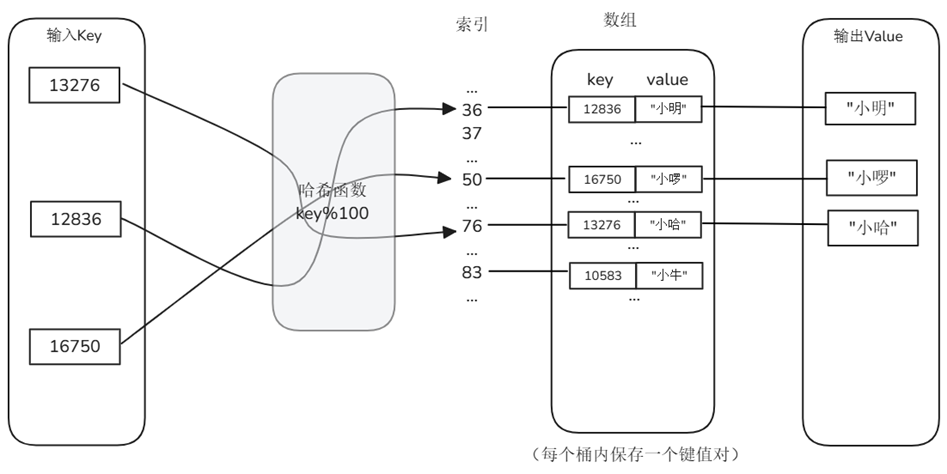

**跳表**

跳表由多级有序链表组成，底层包含全部节点；从底层往上，每层按概率 *p*（常取 0.25‑0.5）抽样上一层“跳点”。这种**概率平衡**让跳表在**无需复杂重平衡**的情况下，也能获得与平衡树相近的性能。 **特性**：

- **平均 O(log N) 查询、插入、删除**——路径期望长度与节点数对数相关。
- **实现简单、更新局部**——只需调整邻接指针，非常适合高并发写入。
- **天然有序**——支持范围扫描、按 rank 定位。Redis ZSET 的底层索引即跳表。

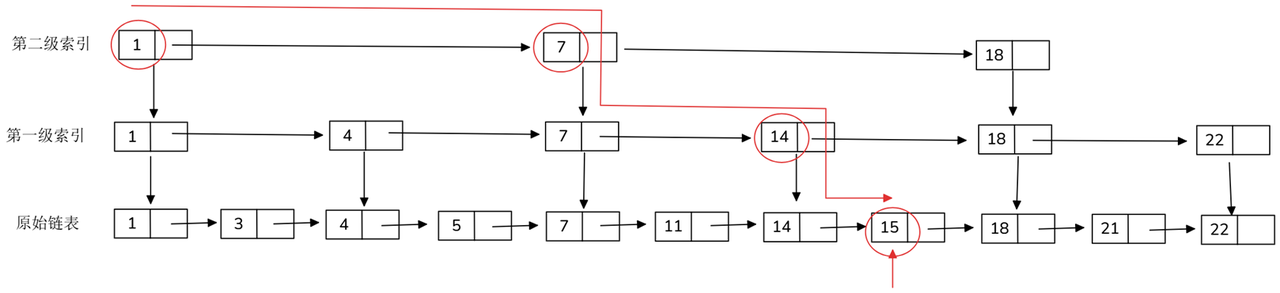


#### **向量索引**

向量索引是用于加速**高维向量数据相似度检索**的索引结构，它的目标是在大规模数据集中，快速找到与某个查询向量最相似（Top-K）的若干个向量。向量索引不仅仅是存储数据，还涉及智能地组织向量嵌入以优化检索过程。目前向量索引基本都采用 **ANN**方法，常用的向量索引结构有IVF、PQ、HNSW等。

|                                                | 特点与适用场景                                               |
| ---------------------------------------------- | ------------------------------------------------------------ |
| **IVF（Inverted File Index）**                 | 先用聚类将数据划分成多个“桶”，查询时只在几个相关桶内做局部搜索，适合大规模数据（如百万级） |
| **PQ（Product Quantization）**                 | 将高维向量压缩为低维离散编码，提高存储密度，适合内存受限的场景 |
| **HNSW（Hierarchical Navigable Small World）** | 基于图结构，构建多个分层的近邻图，适合中高维、查询速度极快，是目前最主流的 ANN 算法之一 |

**KNN & ANN**

​       对于一个RAG系统来说，每次向量检索都可以描述为“给定查询向量 *q*，在向量集合 *V* 中找到距离（或相似度）最小（或最大）的若干个向量。”这一过程被称之为**最近邻搜索（Nearest Neighbor, NN）**。在先前的RAG实践课程中，我们介绍了向量的相似度计算指标（Similarity）。以cosine相似度为例，如果我们期望使用cosine相似度进行最近邻搜索，其过程便是对数据库中的向量逐一进行cosine相似度计算，最终从数据库中找到与目标数据最相似的数据。当检索参数中存在Top K时，即需要查找与目标数据最相似的前K个数据项时，上述搜搜过程便演化为**K最近邻搜索（K-Nearest Neighbor，K-NN）**。然而，当 *|V|* 达到百万甚至亿级时，逐一计算相似度的线性扫描就会变得既耗时又难以扩展。

基于上述原因，目前的向量检索通常采用**近似最近邻搜索算法（Approximate Nearest Neighbor, ANN）**，通过预先构建向量索引，使查询阶段只访问向量空间中的一个子集，用更少的距离计算换取**近似最优解**，从而以**牺牲一定程度的精度为代价进行高效的向量检索**提升系统的使用体验。这种“用精度换速度”的思想在处理大型高维数据集时尤其有用，因为它可以大幅度减少搜索时间，同时仍然保持较高的结果质量。

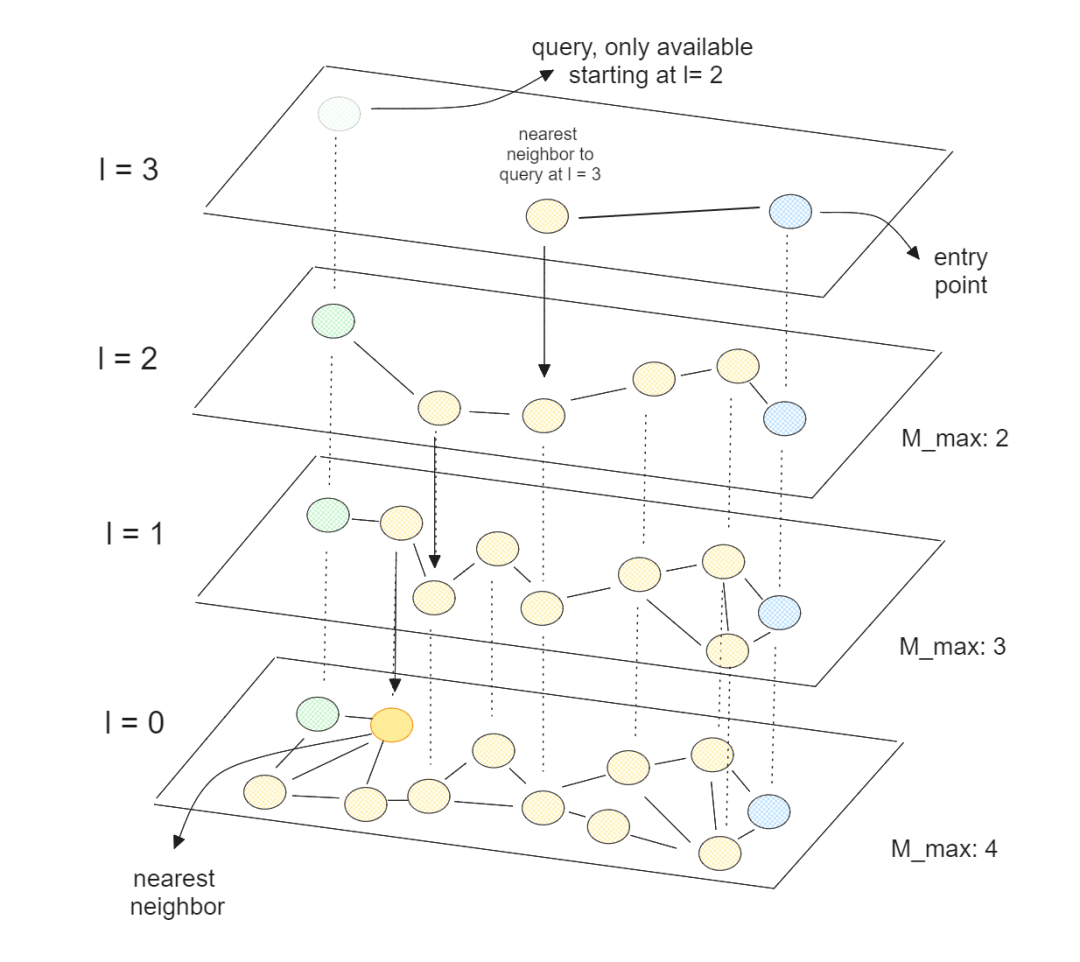

我们以常用的向量索引类型HNSW（Hierarchical Navigable Small World，**层次化可导航小世界**）为例：

- **多层图结构**：构建阶段将向量按距离随机分配到 L ～ 0 多层，小层包含所有向量，大层仅抽样少量“代表点”，形成金字塔。
- **顶层随机起点**：查询向量进入 最高层，任选一个节点作为起始。
- **贪婪近邻跳转**：在当前层反复执行：
  - 计算当前节点邻居与查询向量的距离；
  - 选择距离最近的邻居；
  - 若该邻居比当前节点更近，则跳转过去并继续，否则停止（达到局部最优）。
- **逐层向下**：把“局部最近节点”作为下一层的入口，层层递进，直到底层 0，找到nearest neighbor。

 通过上述查询算法，不必检索那些离查询点较远的相似度较低的元素，进而增加检索效率（同时造成了HNSW找到的是近似最优解），HNSW的时间复杂度是$O(logN)$。

因此，在RAG系统中，将从Embedding模型获得的向量和文档切片及元数据结合起来，组成节点集合，并构建基于ANN的**向量索引**，能够大幅减少检索过程的计算量，提高RAG系统检索阶段的响应速度。

- **倒排文件（IVF）**

IVF是向量索引中最基本的索引技术，它使用K-means聚类等技术将整个数据分成多个簇。数据库中的每个向量都分配给特定的簇。这种结构化的向量排列使用户能够更快地进行搜索查询。当出现新的查询时，系统不会遍历整个数据集。相反，它会识别**最近或最相似的簇**，并在这些簇中搜索特定的文档。IVF仅在相关簇内部进行暴力搜索，而不是在整个数据库中进行搜索，从而提高搜索速度，减少了查询时间。

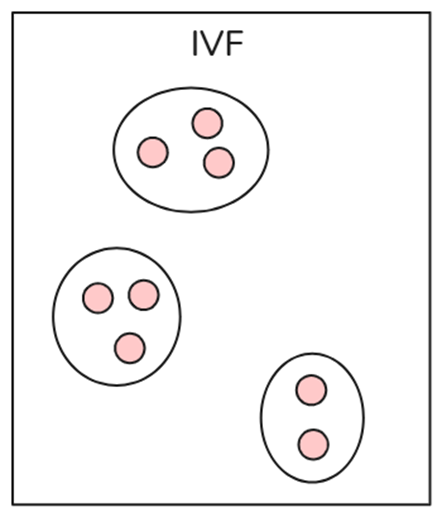

- **乘积量化（PQ）**

乘积量化是一种高效的向量压缩和最近邻搜索（ANN）方法，特别适用于高维数据。它通过将高维向量分解为多个子空间，并分别对每个子空间进行量化，从而减少存储开销，并加速最近邻搜索。

PQ的核心阶段分为：训练、量化、查询

训练：将高维向量划分为M段，对训练集中的每段进行K-means聚类，假设K=256，则每段都有256个中心向量。

量化，有了K个聚类中心向量，便可对他们进行编号，例如ClusterID=0~255。

查询：

将查询向量按照相同规则分段，每段计算与该段K个聚类中心的距离，构成距离表（M*K）。

遍历候选向量，计算距离表中的距离之和。

选出最相似topk向量。

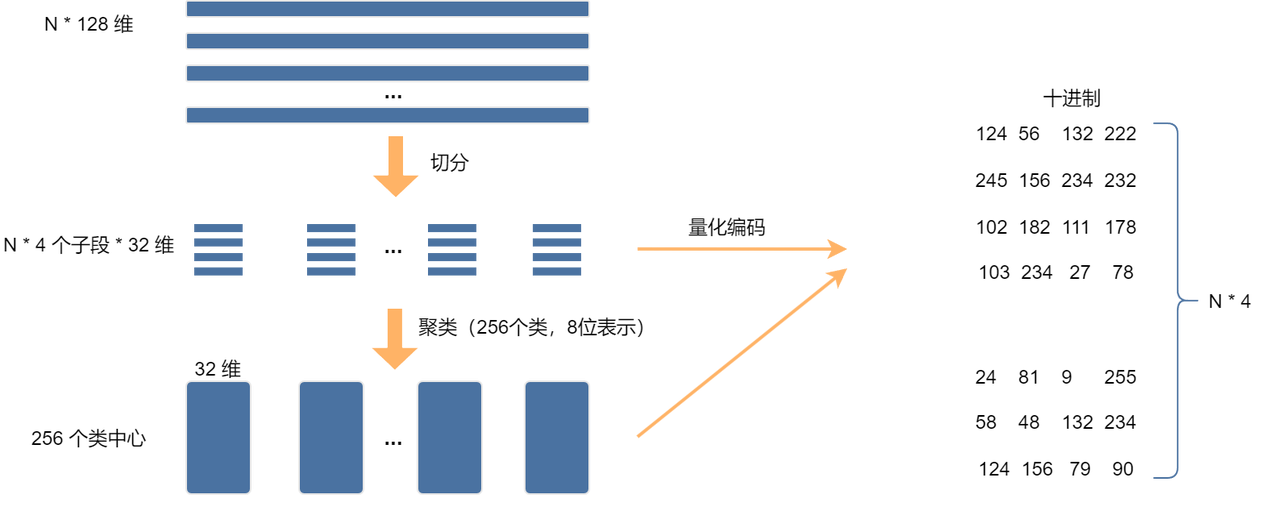

上图展示了 PQ 算法的流程，假设有 N 个 128 维向量，将其划分到 4 个子空间，每个子空间的特征维度为32，然后在每个子空间进行 k-means 聚类，k 取256，此时可以对上述 N*4*32 个向量进行量化编码，将 N*128 的浮点数（32位）向量压缩至 N*4 的八位表示，所占用的存储空间是原来的1/128，极大程度减少了存储空间。进行量化编码后，进行查询时也会节省大量计算，下面我们来看一个简单的例子体会一下，假设我们有以下 4 维向量：

X1=[3.2,4.5,1.8,2.7]

X2=[2.9,4.3,1.5,2.9]

X3=[3.1,4.6,1.9,2.5]

X4=[3.0,4.4,1.7,2.8]

假设我们将 4 维向量拆成 2 个 2 维子向量，则可以得到：

第一部分（前 2 维）：[3.2, 4.5], [2.9, 4.3], [3.1, 4.6], [3.0, 4.4]

第二部分（后 2 维）：[1.8, 2.7], [1.5, 2.9], [1.9, 2.5], [1.7, 2.8]

对每个子空间分别进行 K-Means 聚类（假设有 2 个聚类中心，实际中这个聚类中心需要通过训练得到），则可以得到第一个子空间的聚类中心为：$$C1_1 = [3.0, 4.4]，C1_2 = [3.2, 4.5$$，第二个子空间的聚类中心为：$$C2_1 = [1.8, 2.7]，C2_2 = [1.5, 2.9$$。

对于 X1 = [3.2, 4.5, 1.8, 2.7] 而言最接近的子空间索引为： $$(C1_2，C2_1)$$。因此我们可以用 (2, 1) 这个索引对 X1 进行编码，而不是存储完整的 4 维浮点数。

假设我们有一个查询向量 Q=[3.1,4.5,1.7,2.8]，将查询向量拆分为 [3.1, 4.5] 和 [1.7, 2.8]，然后计算与聚类中心的距离，以第一子空间为例，有：

$$d_{Q-C1_1}=\sqrt{(3.1 - 3.0)^2 + (4.5 - 4.4)^2} \\ = \sqrt{0.01 + 0.01}\\ = \sqrt{0.02}\approx 0.14$$

以同样的方式计算分别得到 $$d_{Q-C1_2}=0.1, d_{Q-C2_1}=0.14, d_{Q-C2_2}=0.22$$，可得量化索引为（2,1），匹配到 X1 和 X3, 然后计算 $$d_{Q-X1}$$和 $$d_{Q-X3}$$，分别得到 0.17 和 0.37，进而得到最接近的匹配向量是 X1.

乘积量化的总体查询复杂度是$$O(m⋅k+n⋅m)$$，其中 m 是子空间个数，k 是聚类中心，n 是数据总量，一般取 k=256。n 达到百万/亿级时，PQ 比暴力搜索更快，进一步地可以结合倒排索引（IVF-PQ） 加速查询，使得查询时间变为亚线性；d 达到 512 维时，PQ 能有效降低存储成本。但 PQ 也会因为拆分高维数据导致每个子空间信息减少而影响精度。此外，PQ 依赖 k-means 聚类，若聚类中心选择不佳，误差可能较大。

- **层次化可导航小世界(HNSW)**

HNSW（Hierarchical Neighbor Small World）是一种将图分为多个层次的图索引方法，是目前向量数据库中常用的一种索引。层次越高对应的节点越少，从高层次的点开始搜索，逐级搜索最终找到目标节点。下图为简单例子，构造好如图所示层级图之后，从蓝色0号点开始检索，在layer2找到与query更近邻的绿色点1，此时layer2已经没有其他点了，于是搜索layer1，在layer1找到2号点，最后在layer0找到了3号点，有效减少计算总量。

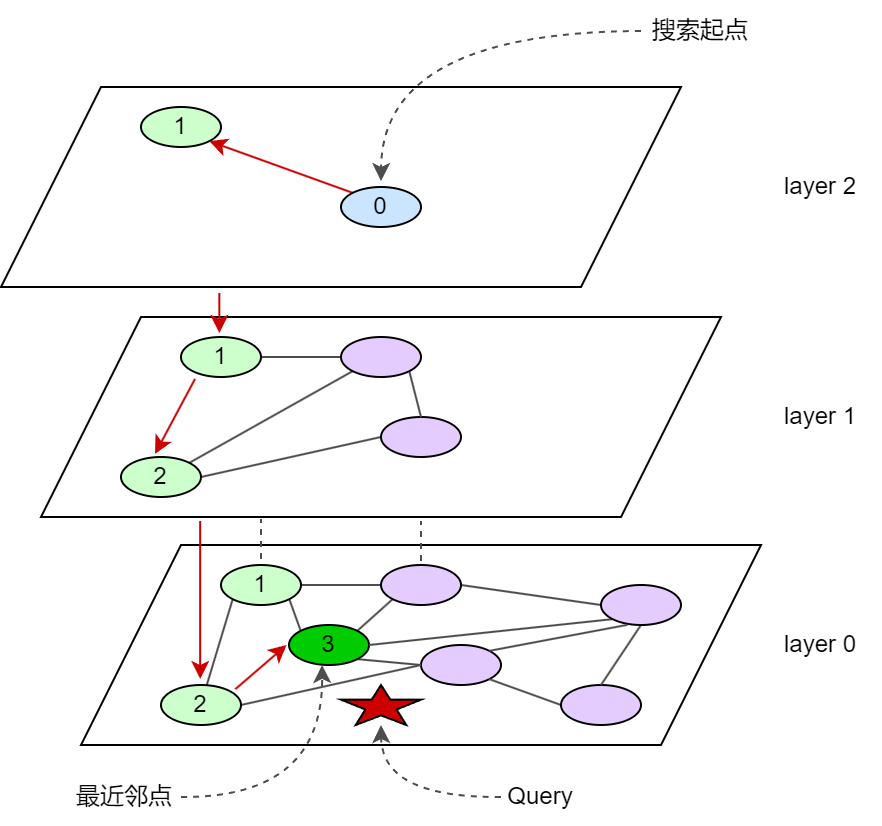

HNSW 检索时间复杂度通常为 O(log n)，其中 n 是数据集中的元素数量。其层次化结构使搜索从顶层开始，逐步向下层细化，每层的节点数呈指数衰减，从而大幅减少搜索路径长度。每一层中，算法利用“小世界网络”特性”（即高聚类和短路径），通过贪心策略快速定位候选节点，避免了全局遍历。每层搜索的复杂度为常数时间，而层数为 O(log n)，因此整体复杂度为 O(log n)。因此 HNSW 适合大规模高维数据的快速近似最近邻搜索。


### 2.4.2 高性能向量数据库Milvus

在企业级RAG系统场景下，有时会出现百万甚至上亿级的数据规模，同时可能会在向量检索的基础上存在着一些特殊的条件限制（比如文档的日期、语言、作者属性过滤），高性能向量数据库Milvus能够轻松驾驭这些复杂的存储及检索需求，这也是LazyLLM对其深度适配的原因。

#### Milvus系统架构

Milvus 的云原生和高度解耦的系统架构确保了系统可以随着数据的增长而不断扩展：

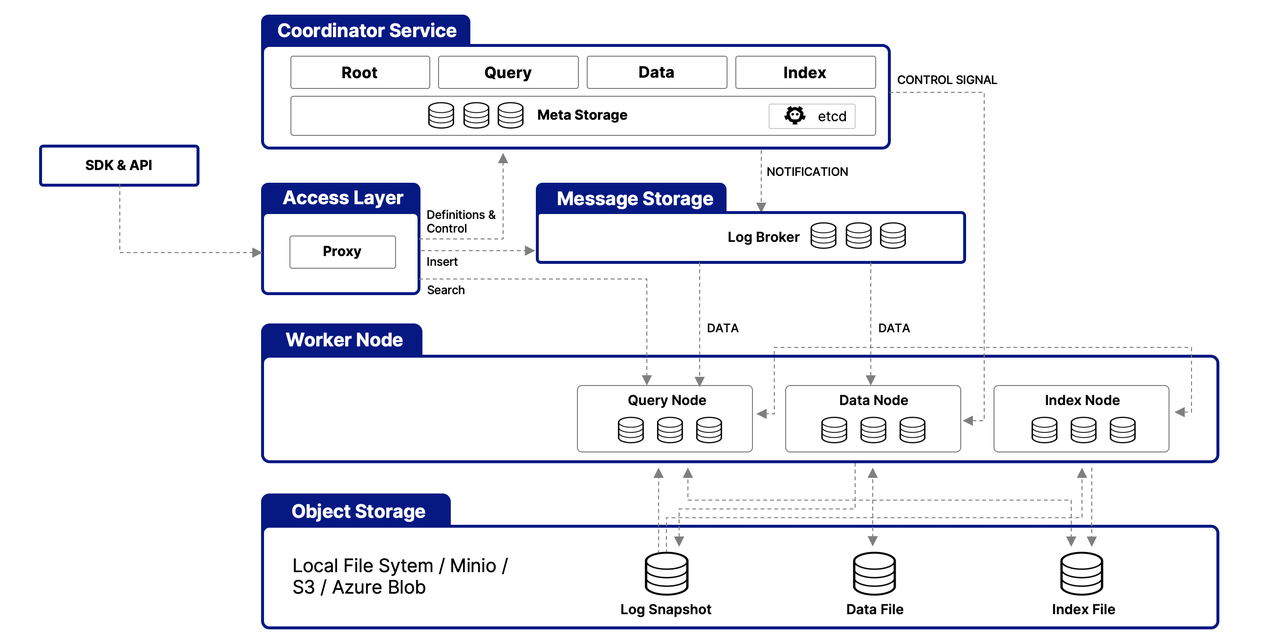

Milvus 本身是完全无状态的，因此可以借助 Kubernetes 或公共云轻松扩展。此外，Milvus 的各个组件都有很好的解耦，其中最关键的三项任务--搜索、数据插入和索引/压实--被设计为易于并行化的流程，复杂的逻辑被分离出来。这确保了相应的查询节点、数据节点和索引节点可以独立地向上和向下扩展，从而优化了性能和成本效率。

此外，Milvus 提供三种部署模式，涵盖各种数据规模--从本地原型到管理数百亿向量的大规模 Kubernetes 集群：

- Milvus Lite 是一个 Python 库，可以轻松集成到您的应用程序中。作为 Milvus 的轻量级版本，它非常适合在 Jupyter Notebooks 中进行快速原型开发，或在资源有限的边缘设备上运行。
- Milvus Standalone 是单机服务器部署，所有组件都捆绑在一个 Docker 镜像中，方便部署。
- Milvus Distributed 可部署在 Kubernetes 集群上，采用云原生架构，专为十亿规模甚至更大的场景而设计。该架构可确保关键组件的冗余。

#### 为什么Milvus可以实现快速检索？

Milvus 的高性能得益于以下几点：

- **硬件感知优化**：为了让 Milvus 适应各种硬件环境，针对多种硬件架构和平台优化了其性能，包括 AVX512、SIMD、GPU 和 NVMe SSD。
- **高级搜索算法**：Milvus 支持多种内存和磁盘索引/搜索算法，包括 IVF、HNSW、DiskANN 等，所有这些算法都经过了深度优化。与 FAISS 和 HNSWLib 等流行实现相比，Milvus 的性能提高了 30%-70%。
- **C++ 搜索引擎**：向量数据库性能的 80% 以上取决于其搜索引擎。由于 C++ 语言的高性能、底层优化和高效资源管理，Milvus 将 C++ 用于这一关键组件。最重要的是，Milvus 集成了大量硬件感知代码优化，从汇编级向量到多线程并行化和调度，以充分利用硬件能力。
- **面向列**：Milvus 是面向列的向量数据库系统。其主要优势来自数据访问模式。在执行查询时，面向列的数据库只读取查询中涉及的特定字段，而不是整行，这大大减少了访问的数据量。此外，对基于列的数据的操作可以很容易地进行向量化，从而可以一次性在整个列中应用操作，进一步提高性能。

#### 标量过滤

当在 Milvus 中进行向量检索时，可能希望通过一些标量字段（例如，数值、字符串字段）来进行筛选，以实现更精准的搜索结果。例如，在图像检索中，可以根据图片上传日期等标量字段来筛选结果。然而，标量字段过滤的效率直接影响最终查询的速度。为了解决这一瓶颈，Milvus 引入了标量字段索引，它可以有效组织标量字段的数据，并结合倒排索引、自动索引等技术，极大提升查询效率。

## 三、优化模型推理性能

RAG 系统之所以能够根据外部文档解答用户的问题主要是得益于大模型的发展。通常来说模型参数越多，效果上的增益越多（例如在SuperCLUE开源模型排行榜单上，排名第4往上的模型都是 300 亿往上的参数量，以2024年12月榜单为基准）。但随着模型规模的不断增大，推理时间（即模型预测的时间）已成为影响系统响应速度和效率的一个关键因素。接下来，我们将探讨几种方法来优化模型推理的时间，重点关注如何通过基于软硬件加速模型推理以及模型量化、模型蒸馏等技术来提高系统性能。

基于软硬件的推理加速通常不需要开发者自行进行优化，往往可以通过更换硬件，切换技术方案即可实现。

### 3.1 大模型推理速度评测指标

大模型推理服务目标是首token输出尽可能快、吞吐量尽可能高以及每个输出token的时间尽可能短，即模型服务能够尽可能快地支持尽可能多地为用户生成文本。

- TTFT（Time to First Token，首字延迟）：从向模型输入提示词开始到模型生成第一个token所需时间。
- TPOT（Time Per Output Time）：模型在输出阶段（Decode）每个输出token的延时。
- Throughput：吞吐量，针对模型服务，模型服务在单位时间内能处理的token数量。
- BS（Batch Size）：针对模型服务，即服务合并计算用户请求的数量（提高吞吐量的方法一般是提高BS，但是提高BS会一定程度上影响每个用户的时延）。

大模型推理速度的影响因素主要是：

1. 计算量
   1. 模型大小（参数量） -> 蒸馏
   2. 使用低精度数据
   3. 量化
2. 计算性能
   1. 芯片计算能力
   2. 算子实现情况
   3. 选取合适的并行策略，优化卡间互联
   4. 选用一个好的推理框架

### 3.2 硬件加速

在现代 AI 应用中，GPU、TPU 和专用 AI 加速芯片是提升推理速度的关键工具。对于大模型推理而言，通常涉及数以亿计的参数和复杂的数学运算，包含大量的浮点运算，如矩阵乘法和非线性激活函数等。这些运算对计算精度和速度都有很高的要求。我们日常在个人笔记本等使用的 CPU 适合通用任务，它的核心较少，适合顺序执行任务。而 GPU、TPU 等是专门为并行计算设计的硬件，以 GPU 为例，它有成千上万个小核心，可以同时进行大量简单的计算，非常适合矩阵运算，因此深度学习推理更快，是目前主流的 AI 计算硬件。此外，深度学习框架的支持也是重要原因，GPU/TPU 拥有强大的软件生态系统，包括深度学习框架和库，例如 CUDA，这些框架和库为这些硬件提供了优化的算法和 API，使得大模型的开发变得更加容易和高效。也因此，GPU/TPU 的价格相比 CPU 更昂贵，不同型号的 GPU/TPU 之间的计算性能相差也比较大，尤其是大模型推理任务对硬件的需求更高，要求更大的显存和更高的计算效率，因此如何在有限的硬件资源基础上进行高效的大模型推理也是目前的研究热点之一。

### 3.3 软件加速

软件加速主要是通过优化计算方式、减少冗余操作、充分利用硬件并行性等手段来提升推理效率。近年来，随着大模型的发展，专门针对推理优化的技术和框架不断涌现，以下是几个典型的软件加速方案：

（1） Flash Attention：Flash Attention 是一种优化 Transformer 模型中注意力（Attention）计算的技术，专门用于减少显存占用和加速推理。传统的注意力计算会创建一个完整的注意力矩阵，需要大量的显存和计算资源。Flash Attention 利用显存读写优化和并行计算，避免了不必要的内存访问，从而加快推理速度。整体上，Flash Attention 通过减少 GPU 显存占用，使得更大的模型能在有限显存的 GPU 上推理，推理速度相较于标准 Attention 提升 5-9 倍，同时可以降低显存消耗。

（2）vLLM（Very Large Language Model Inference）：VLLM 是一个专门优化大模型推理的框架，适用于 Transformer 模型。VLLM 通过 Paged Attention（分页注意力）进一步优化显存管理，使得推理时可以更有效地利用 GPU 显存，减少重复计算，提升长文本推理速度。此外VLLM支持并行批处理，支持多个请求并行推理，从而提高吞吐量。VLLM 能够让更大的模型在相同的 GPU 资源下运行，使用 Continuous Batching 技术提升同样的模型推理效率至高可以提升至 23 倍 [数据来源与 VLLM 官方文档]，适用于需要处理大量请求的场景。类似的框架还有LightLLM、LMDeploy等。

以上这些方案都是针对特定硬件提出的软件加速方法，通常框架研发方会对多数模型进行适配，用户只需下载对应模型权重，利用对应的库即可实现加速推理效果。虽然这些方法可以加速模型推理，但模型本身的参数量并没有下降或产生变化，效果好一点的模型仍然是百亿级别，仍然需要大量的硬件支持。因此下面为大家介绍两种技术在保留模型能力的基础上减少对大量硬件的依赖。


### 3.4 模型量化

模型量化是通过将模型中的浮点数权重转换为更低精度的数值（例如，从32位浮点数转换为8位整数）来减少模型的存储需求和计算开销的技术。模型量化通过将高精度的权重转换为更低精度的数值，可以显著压缩模型体积、降低计算量和显存占用，在支持低精度指令的硬件上可大幅提升推理速度，并在分布式场景中减少帯宽开销，使大模型得以在资源受限设备上高效运行。

常见的量化方法包括：权重量化，将模型的权重从 32 位浮点数转换为 8 位整数甚至 4 位整数；激活量化，是对神经网络的激活值进行量化，进一步减少计算资源需求。

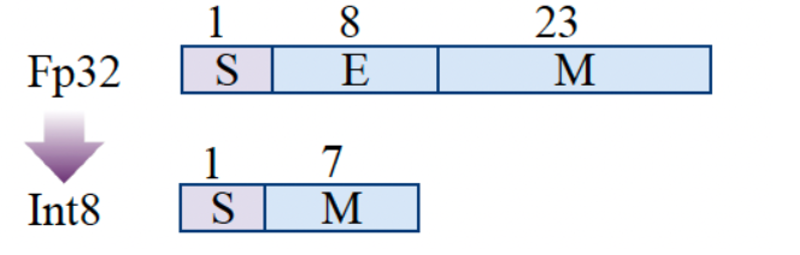

​      常见的量化精度包括INT8、INT4等。通过量化，RAG系统中的生成模型和检索模型都能显著提高推理速度，减少内存占用，从而加快整体系统响应时间。实际中您可能会看到 W8A8, W4A16 等多种量化模型的规格，其中 W 表示的是权重（Weight），A 表示的是激活（Activation），那么 W8A8 表示的就是权重和激活都是 8 位整数。目前常用的大模型量化方法有 GPTQ、AWQ等，下文简单介绍 AWQ 让您对模型量化技术有初步的认识，实际实践中，有 AutoGPTQ、AutoAWQ 等可直接调用的库实现这些量化操作。

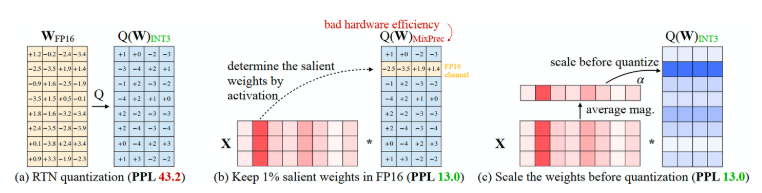

AWQ（Activation-aware Weight Quantization for LLM Compression and Acceleration）是较为常用的一种量化技术，它的原则保护更“重要”的权重不进行量化。深度学习中标准的量化流程是对所有权重进行FP16 -> INT3/4 量化，但AWQ 认为大语言模型的权重并非同等重要，有一小部分关键权重（salient weights）对于模型性能的影响远大于其他权重。如果在量化过程中跳过这些关键权重的量化，可以在不进行额外训练或回归的情况下，缓解由于量化损失导致的性能下降（即上图(b)）。但这种做法会因为精度不同而导致硬件效率低下的问题。AWQ 提出了一种通过逐通道缩放来减少显著权重的量化误差的方法（如上图(c)），可以有效规避硬件效率问题。具体来说，在进行权重量化前进行通道权重计算，即每个通道的平均幅度（magnitude），得到这个权重后对通道进行缩放，然后再进行量化步骤。因此 AWQ 不依赖于任何回归或反向传播，在量化过程中需要更少的数据，并且可以将LLM的知识保留在校准集分布之外。

根据 AWQ 量化方法论文提供的数据，使用 AWQ 量化后的模型在同等情况下相比于 FP16 模型速度提升了 3 倍，并将对内存需求降低了 3 倍。以 AWQ 量化的 Qwen-72B 模型为例，二者在MMLU，C-EVAL，IFEval上的均分差异为 0.9，分别为81.3和80.4，但对硬件的要求分别为 144GB 和 48GB，由此可见量化模型可以在保留原模型较高准确度的基础上节省大量显存需求。

在模型开源社区中，开发者可以轻松获取大量优秀的量化模型。

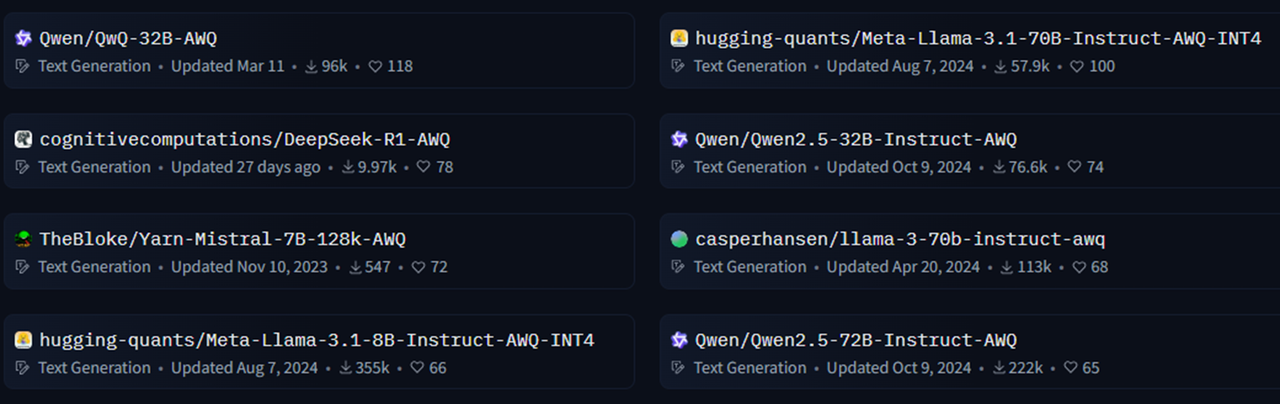



### 3.5 模型蒸馏

随着深度学习模型规模的不断增长，计算资源和推理时间的消耗也在大幅增加。模型蒸馏（Knowledge Distillation，KD） 作为一种模型压缩技术，可以在不显著牺牲模型性能的情况下，将大型复杂模型的知识转移到较小的模型中，使得推理更高效、更易于部署。这一技术最早由 Hinton 等人在 2006 年提出，并在 2015 年被进一步系统化。近年来，随着大语言模型（LLM）的兴起，在多个领域得到了广泛应用。

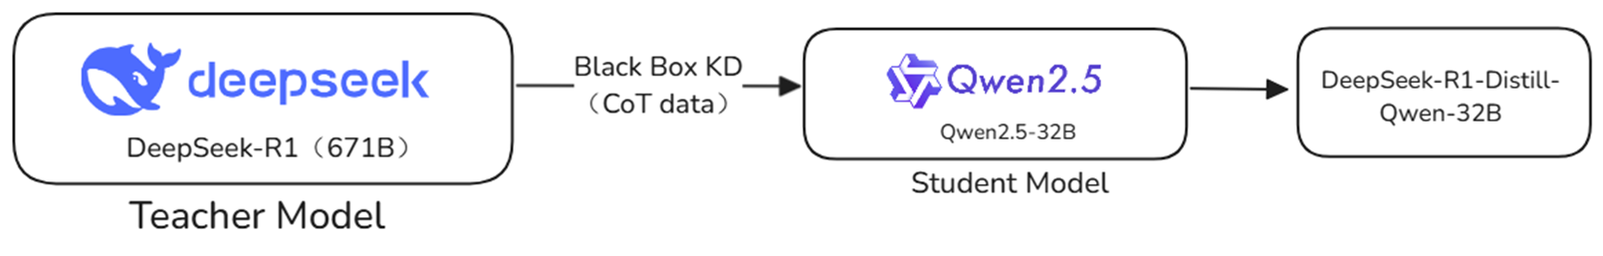

模型蒸馏的核心思想是使用一个精度很高的大模型（教师模型，Teacher Model）来指导一个较小的模型（学生模型，Student Model）进行学习，使其能够在较低计算成本下达到接近教师模型的性能。相比于直接训练一个小模型，学生模型在蒸馏过程中可以学习到教师模型的知识结构，使其泛化能力更强。一个典型的例子是 DistilBERT，它是从 BERT-base 蒸馏而来的模型，仅有原始模型的 40% 大小，却能保持 97% 的性能，同时推理速度提升了 60%（数据源于 DistilBERT 论文）。这一案例充分说明了模型蒸馏在优化推理效率方面的重要作用。

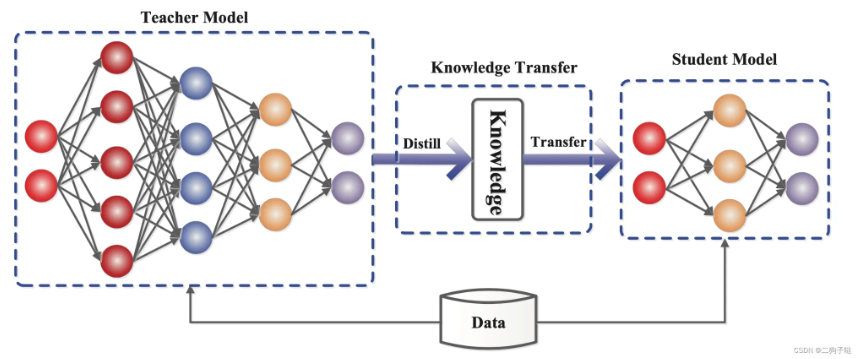

通常，知识蒸馏的方式可以分为两类：

(1) 黑盒知识蒸馏（Black-box Knowledge Distillation）：在黑盒蒸馏模式下，教师模型被视为一个不可访问的黑盒，我们只能获取其最终的输出。训练学生模型的方式是让其模仿教师模型的输出，通过最小化两者之间的差距来优化学生模型的参数。这种方法的计算成本低，但由于缺乏教师模型的内部信息，蒸馏效果通常不如白盒蒸馏。

(2) 白盒知识蒸馏（White-box Knowledge Distillation）：在白盒蒸馏模式下，除了最终的输出，教师模型的隐藏层特征、中间表示甚至注意力机制等信息也是可访问的。学生模型不仅要学习教师模型的输出分布，还可以通过模仿其中间层特征、注意力矩阵等来进一步缩小与教师模型的差距。白盒蒸馏通常能获得更好的性能，但需要更复杂的训练方法。

通过知识蒸馏可以实现轻量化推理。大模型（如 GPT-4、DeepSeek）通常参数量巨大，推理时需要多个 GPU 并行计算，而蒸馏后的模型可以在单张 GPU 甚至 CPU 上推理，大幅降低部署成本。例如 DeepSeekR1（671B） 需要 16 张 80G 的显卡才能部署推理服务，但通过知识蒸馏，以 7B 模型为例，只需 14G 显存。

尽管知识蒸馏有诸多优势，但在实际应用中仍然存在一定的挑战，例如因为学生模型的容量比教师模型小，可能无法完全复现教师模型的能力。相比直接量化或剪枝，知识蒸馏需要额外的训练步骤，并且需要选择合适的损失函数。此外，虽然蒸馏后的学生模型推理更快，但训练或部署一个高质量的教师模型可能仍然需要大量算力。

在实际应用中，蒸馏和量化可以结合使用，例如使用蒸馏得到一个小模型后，再对其进行量化，从而在保证精度的同时最大程度降低计算成本。关于模型蒸馏的更多细节本节不再赘述，感兴趣的读者可以跳转至选修内容进行DeepSeekR1的蒸馏教程进行学习。


### 3.6 模型参数精度

大模型的训练和推理经常涉及到**精度**的概念，精度高更准确，但也会带来更高的计算和存储成本。较低的精度会降低计算精度，但可以提高计算效率和性能。所以多种不同精度，可以让你在不同情况下选择最适合的一种。

浮点数精度（Floating Point，FP）：最原始的精度，由符号位（sign，正/负）、指数位（exponent，表示整数部分范围）、尾数位（fraction，表示小数部分）组成，常见精度由FP64、FP32、FP16（FP8和FP4不是IEEE的标准格式）

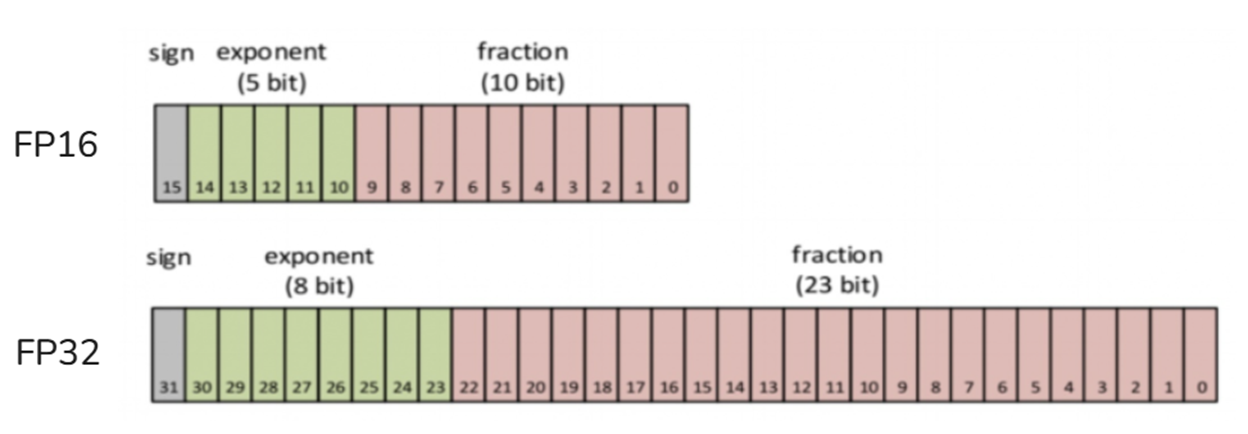

$$\text{value} = (-1)^s \times \text{1.f} \times 2^{e - \text{bias}} \\ \text{bias} = 2^{\text{bitlen}(e) - 1} - 1$$

- TF32：TF32（Tensor Float 32）是英伟达针对机器学习设计的一种特殊的数值类型，用于替代FP32。首次在A100 GPU中支持。其由1个符号位，8位指数位（对齐FP32）和10位小数位（对齐FP16）组成，实际只有19位。在性能、范围和精度上实现了平衡。

In [ ]:
import torch
//是否支持tf32
torch.backends.cuda.matmul.allow_tf32
//是否允许tf32，在PyTorch1.12及更高版本中默认为False
torch.backends.cudnn.allow_tf32

- BF16：BF16（Brain Float 16）由Google Brain提出，也是为了机器学习而设计。由1个符号位，8位指数位（和FP32一致）和7位小数位（低于FP16）组成。所以精度低于FP16，但是表示范围和FP32一致，和FP32之间很容易转换。

In [ ]:
import transformers
transformers.utils.import_utils.is_torch_bf16_gpu_available()

- FP8：FP8是H100及之后的显卡特有的一种数据表示方式，目前国产卡几乎都不具备该格式，有E4M3和E5M2两种常见的变种格式。

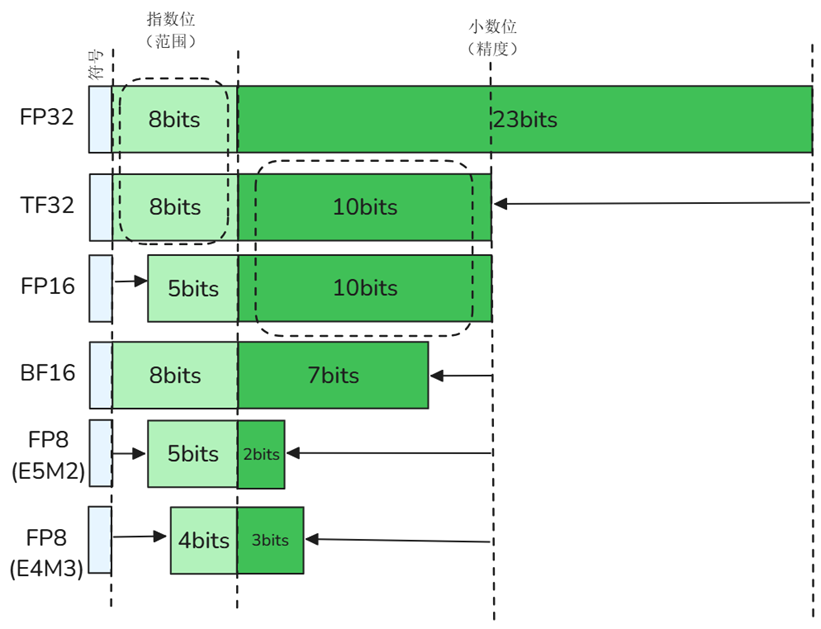

### 3.7 并行策略

**Tensor Core**

Tensor 核心（Tensor Core）是 NVIDIA GPU在A100及之后才有的硬件加速单元，相比传统 CUDA 核心（CUDA Core），Tensor 核心可以在一次运算中并行处理更多数据，从而大幅提升**矩阵乘法**（Matrix Multiplication, GEMM） 速度，使深度学习训练更高效。

|                  | **CUDA Core**                  | **Tensor Core**                        |
| ---------------- | ------------------------------ | -------------------------------------- |
| **主要用途**     | 通用计算（GPGPU）              | AI训练&推理                            |
| **支持数据类型** | FP32、INT32 等                 | FP16、TF32、INT8、INT4、FP64 等        |
| **性能特点**     | 通用性强，支持各种并行计算任务 | 专用硬件加速，最高提升16倍，吞吐量更高 |
| **典型应用**     | 图形渲染、科学计算、高性能计算 | 深度学习模型训练与推理                 |


**CUDA加速**

CUDA（Compute Unified Device Architecture）是 NVIDIA 提供的一种并行计算平台和编程模型，它允许开发者使用类似 C/C++ 的语言在 GPU 上进行通用计算（即 GPGPU：General-Purpose computing on Graphics Processing Units）

- 并行计算：GPU 有上千个核心，CUDA 把计算任务分发给大量线程，使大量计算任务瞬间完成
- 高效内存管理：CUDA 提供 shared memory、global memory 等机制，让内存访问尽量并行、高速
- 张量操作优化：很多深度学习库（如 PyTorch）底层用 CUDA 实现了高性能的 matmul、conv、norm 等操作
- 自动调用 GPU：框架在支持 CUDA 的情况下，可以自动将数据搬到 GPU，用CUDA核心计算，然后返回结果
- 支持混合精度计算（Tensor Core）：在新一代 GPU 上，CUDA 能调用 Tensor Core，用 float16 或 int8 等低精度加速计算，几乎不损失模型精度

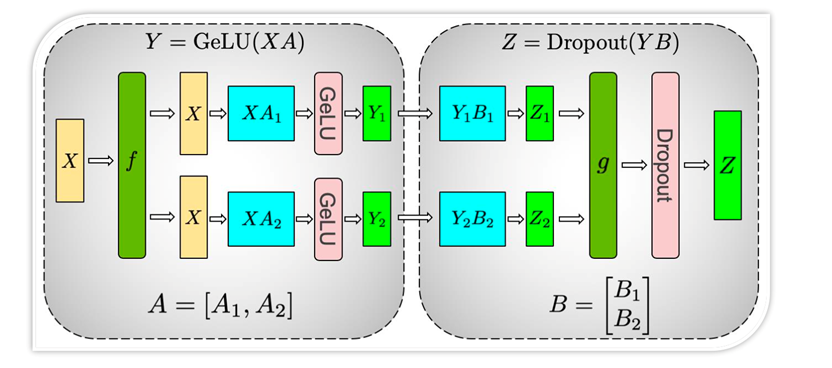

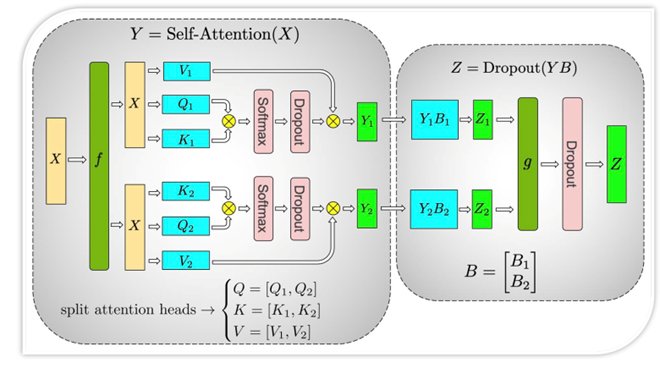

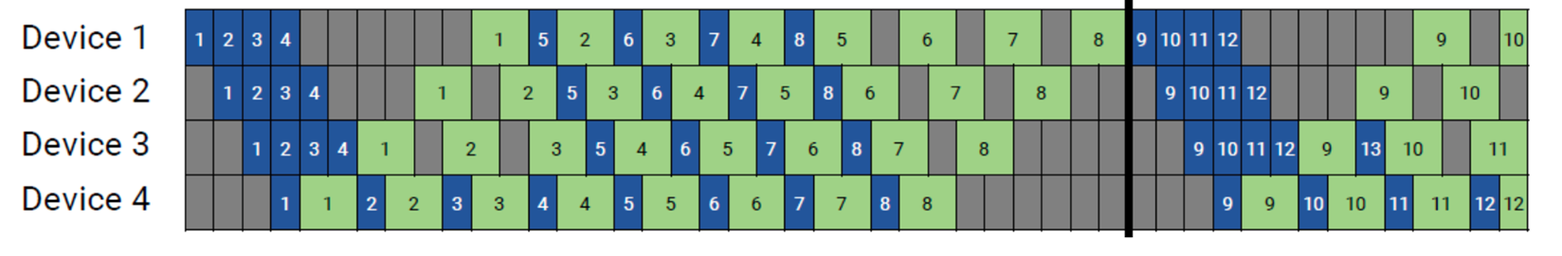


### 3.8 稀疏模型结构 – MoE

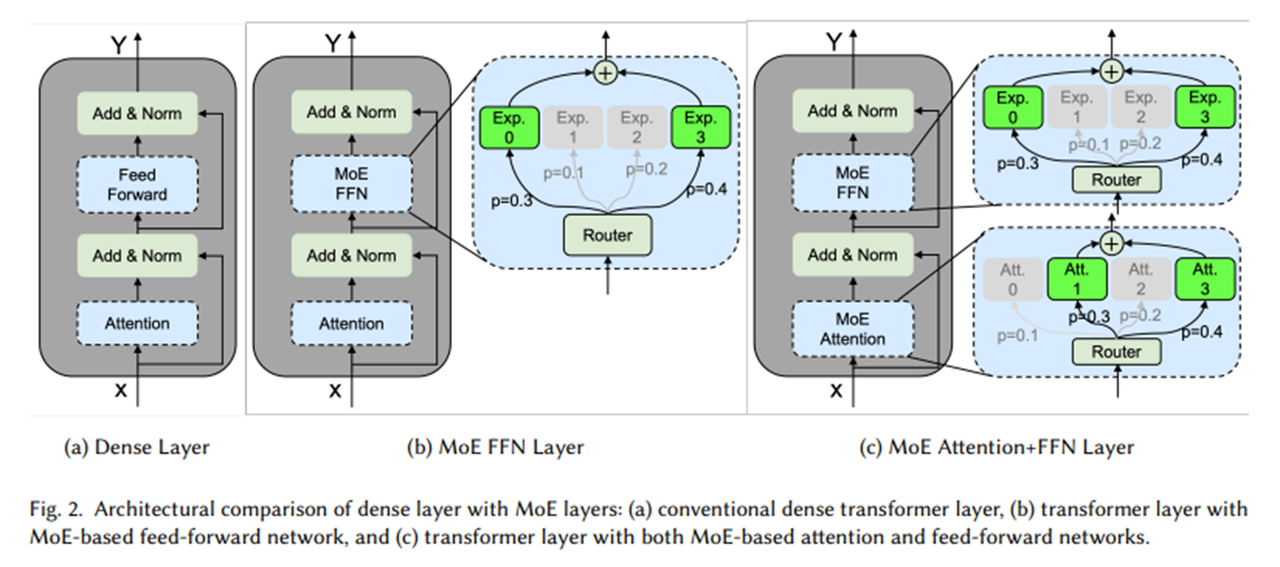

### 3.9 更好的推理框架

在模型不变的情况下，通过选择更好的推理框架，也可以提升大模型的推理性能。当前主流的模型推理框架有Ollama、LightLLM、vLLM以及LMDeploy等等。

- **Ollama**
  - 预打包模型：内置了LLaMA、Mistral等多种模型。
  - 硬件适配性强：针对日常使用的硬件进行了CPU和GPU推理优化，无论是MacBook、PC还是边缘设备，都能流畅运行AI模型。
  - 操作便捷：提供简洁的API和CLI，只需简单配置，就能快速启动大语言模型。
- **LightLLM**
  - 轻量级设计：占用资源少，易于部署和扩展，方便快速上手进行本地部署和定制修改。
  - 高性能：通过多种优化技术如三进程异步协作、Token Attention等，实现高速推理，获得更高的吞吐量。
  - 易用性：提供 Docker 容器和详细文档，简化使用流程，降低使用门槛。
- **vLLM**
  - PagedAttention技术：突破传统KV缓存机制，实现显存分页管理，支持超长序列生成（如10万token对话）。
  - 吞吐量领先：在 A100 GPU上可达传统框架3倍以上吞吐量，支持动态批处理。
  - 生态兼容性：原生支持HuggingFace模型格式，兼容PyTorch生态。
- **LMDeploy**
  - Turbomind引擎：采用异步流水线并行，延迟降低至50ms级别
  - 量化部署工具链：支持W4A16量化，模型体积压缩4倍
  - 动态批处理：智能合并不同长度请求，GPU利用率达90%+

LazyLLM已完成LightLLM、vLLM、LMDeploy三种框架的完美适配，开发者可以根据自己的实际需求，灵活选择推理框架，以实现最适合自己的模型推理体验。

|          | **Ollama**                  | **LightLLM**      | **vLLM**           | **LMDeploy**   |
| -------- | --------------------------- | ----------------- | ------------------ | -------------- |
| 核心优势 | 个人PC运行LLM               | 轻量化，极简部署  | 高并发处理         | 国产高性能框架 |
| 适用场景 | 个人电脑/较小模型           | 个人调试/原型开发 | 企业级服务部署     | 国产化部署方案 |
| 硬件要求 | MacBook、PC、边缘设备可以跑 | 中端显卡也能跑    | 需NVIDIA高性能显卡 | 中端显卡也能跑 |
| 开源协议 | MIT                         | Apache 2.0        | Apache 2.0         | Apache 2.0     |


### 3.10 端侧推理框架

| **端侧推理框架**           | **主要特点**                                                | **典型应用芯片**                |
| -------------------------- | ----------------------------------------------------------- | ------------------------------- |
| **MLC   LLM**              | 多后端编译（WebGPU、Metal、CUDA、Vulkan），一套代码多平台跑 | 手机（iOS/Android）、浏览器、PC |
| **llama.cpp**              | 用纯C/C++写的推理器，极致小巧，适配CPU/Metal/AVX            | PC   CPU、Mac (M系列)、移动端   |
| **GGML/GGUF**              | 格式   + 量化推理库，配合 llama.cpp 使用                    | CPU优先（包括嵌入式CPU）        |
| **Core   ML Tools**        | 苹果官方推理框架，专为Apple Silicon（M系列、A系列芯片）优化 | iPhone、MacBook、iPad           |
| **OpenVINO**               | Intel出品，优化x86 CPU / VPU / Movidius NPU推理             | 边缘计算、工控设备              |
| TensorFlow   Lite (TFLite) | TensorFlow的端侧轻量版本，支持量化和硬件加速                | 手机、微型设备（树莓派等）      |
| ONNX   Runtime Mobile      | ONNX推出的轻量版runtime，支持移动端加速                     | Android、iOS                    |

## 总结

构建高效的 RAG 系统，需要从多个层面优化以提升响应速度和运行效率。启动时间的优化可以通过持久化存储减少数据加载和索引构建的开销，同时结合缓存机制降低重复计算，从而加快系统的二次启动时间。运行时的检索速度对整体性能至关重要，采用高效的向量数据库（如 Milvus）可以提高向量检索效率，同时配合关键词索引或倒排索引等技术，进一步减少查询延迟。在模型推理方面，量化技术（如 GPTQ、AWQ）能够降低计算负担，提高推理速度，而知识蒸馏则可以将大模型的知识迁移至更小的模型，使其在减少计算成本的同时保持较高的性能。综合这些优化策略，可以显著提升 RAG 系统的稳定性和效率，使其在实际应用中更具实用价值。

## 参考文献

近似邻近图：https://arxiv.org/pdf/2101.12631

HNSW：https://arxiv.org/abs/1603.09320

Flash Attention: https://arxiv.org/pdf/2205.14135

VLLM: https://docs.vllm.ai/en/latest/

AWQ：https://arxiv.org/pdf/2306.00978

DistillBERT：https://arxiv.org/pdf/1910.01108